# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [2]:
import os
#Pre-create Required Folders:
if not os.path.exists('./parsed_data'):
    os.makedirs('./parsed_data')
if not os.path.exists('./checkpoint'):
    os.makedirs('./checkpoint')
if not os.path.exists('./output'):
    os.makedirs('./output')
if not os.path.exists('./logs'):
    os.makedirs('./logs')
if not os.path.exists('./models/model'):
    os.makedirs('./models/model')


In [40]:
# Cello Data Provided on Github
# if not os.path.exists('./Bach2'):
#     os.makedirs('./Bach2')

url = "https://raw.githubusercontent.com/WashieMugo/Generative_Deep_Learning_2nd_Edition/main/download_bach_cello_data.sh"
td = "Bach2/download_bach_cello_data.sh"
!wget $url -O $td
!chmod +x $td
! cd Bach2/ && ./download_bach_cello_data.sh
! cd ..

--2024-10-30 18:49:30--  https://raw.githubusercontent.com/WashieMugo/Generative_Deep_Learning_2nd_Edition/main/download_bach_cello_data.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2000 (2.0K) [text/plain]
Saving to: ‘Bach2/download_bach_cello_data.sh’

Bach2/download_bach 100%[===================>]   1.95K  --.-KB/s    in 0s      

2024-10-30 18:49:30 (40.6 MB/s) - ‘Bach2/download_bach_cello_data.sh’ saved [2000/2000]

./download_bach_cello_data.sh: line 4: cd: /bach-cello/: No such file or directory
Downloading...
🚀 Done!
./download_bach_cello_data.sh: line 45: unexpected EOF while looking for matching `"'
./download_bach_cello_data.sh: line 46: syntax error: unexpected end of file


In [3]:

# # Downloading the Batch MID files:

# import requests
# import zipfile

# # Define the URL and target directory
# url = "https://www.bachcentral.com/bach.zip"
# target_dir = "Bach/"

# # Create the target directory if it doesn't exist
# os.makedirs(target_dir, exist_ok=True)

# # Download the zip file
# response = requests.get(url, stream=True)
# zip_file_path = os.path.join(target_dir, "bach.zip")

# with open(zip_file_path, "wb") as file:
#     for chunk in response.iter_content(chunk_size=8192):
#         file.write(chunk)

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
#     zip_ref.extractall(target_dir)

# print(f"Downloaded and extracted to: {target_dir}")

Downloaded and extracted to: Bach/


In [ ]:
# !ls /data/Bach/bach/cellosui

In [3]:
#dowload utility file:
import os
import urllib.request

url = "https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/01_transformer/transformer_utils.py"
filename = "transformer_utils.py"

if not os.path.exists(filename):
    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(url, filename)
    print(f"{filename} downloaded successfully.")
else:
    print(f"{filename} already exists.")

transformer_utils.py already exists.


In [5]:
#installing music21
!pip install music21

In [4]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

## 0. Parameters <a name="parameters"></a>

In [5]:

PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "./parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 1500
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [6]:
# Load the data
file_list = glob.glob("./Bach2/*.mid") # ./Bach/bach/cellosui/*.mid"
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [7]:
parser = music21.converter

In [8]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [10]:
# install musecore3
!apt-get install -yq musescore3

Reading package lists...
Building dependency tree...
Reading state information...
musescore3 is already the newest version (3.2.3+dfsg2-11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


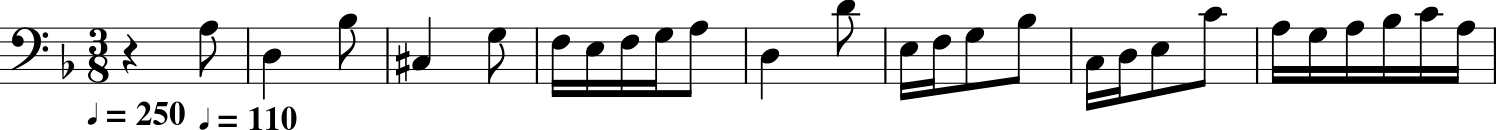

In [9]:
us = music21.environment.UserSettings()
us['musicxmlPath'] = '/usr/bin/mscore3'
us['musescoreDirectPNGPath'] = '/usr/bin/mscore3'

example_score.show()

In [11]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7c601f9f3dc0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250>
    {0.0} <music21.key.Key of F major>
    {0.0} <music21.meter.TimeSignature 3/8>
    {0.0} <music21.note.Rest quarter>
    {1.0} <music21.tempo.MetronomeMark allegretto Quarter=110>
    {1.0} <music21.chord.Chord A3>
{1.5} <music21.stream.Measure 2 offset=1.5>
    {0.0} <music21.chord.Chord D3>
    {1.0} <music21.chord.Chord B-3>
{3.0} <music21.stream.Measure 3 offset=3.0>
    {0.0} <music21.chord.Chord C#3>
    {1.0} <music21.chord.Chord G3>
{4.5} <music21.stream.Measure 4 offset=4.5>
    {0.0} <music21.chord.Chord F3>
    {0.25} <music21.chord.Chord E3>
    {0.5} <music21.chord.Chord F3>
    {0.75} <music21.chord.Chord G3>
    {1.0} <music21.chord.Chord A3>
{6.0} <music21.s

In [12]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing ./Bach2/cs1-3cou.mid


<ipython-input-12-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


820 notes parsed
2 Parsing ./Bach2/cs2-6gig.mid
1555 notes parsed
3 Parsing ./Bach2/cs3-6gig.mid
2516 notes parsed
4 Parsing ./Bach2/cs3-4sar.mid
2857 notes parsed
5 Parsing ./Bach2/cs2-5men.mid
3384 notes parsed
6 Parsing ./Bach2/cs1-1pre.mid
4042 notes parsed
7 Parsing ./Bach2/cs1-4sar.mid
4305 notes parsed
8 Parsing ./Bach2/cs5-1pre.mid
5614 notes parsed
9 Parsing ./Bach2/cs6-6gig.mid
6786 notes parsed
10 Parsing ./Bach2/cs5-5gav.mid
7988 notes parsed
11 Parsing ./Bach2/cs1-2all.mid
8909 notes parsed
12 Parsing ./Bach2/cs3-3cou.mid
9898 notes parsed
13 Parsing ./Bach2/cs4-6gig.mid
10869 notes parsed
14 Parsing ./Bach2/cs3-1pre.mid
11850 notes parsed
15 Parsing ./Bach2/cs1-5men.mid
12497 notes parsed
16 Parsing ./Bach2/cs2-4sar.mid
12834 notes parsed
17 Parsing ./Bach2/cs4-1pre.mid
13651 notes parsed
18 Parsing ./Bach2/cs4-5bou.mid
14975 notes parsed
19 Parsing ./Bach2/cs5-6gig.mid
15424 notes parsed
20 Parsing ./Bach2/cs6-5gav.mid
16230 notes parsed
21 Parsing ./Bach2/cs4-2all.mid
1

In [13]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 G3 F#3 A3 E-3 G2 B3 A3 G3 F#3 E3 B2 E-3 E2 E3 F#3 G3 A3 B3 C4 D4 F3 B2 E3 F3 G3 F3 E3 D3 E3 C3 C2 C3 D3 E3 F#3 G3 E3 C#3 G3 A3 G3 A3 G3 C#3 G3 C#3 G3 A3 G3 C3 F#3 ...

Duration string
 0.25 0.25 0.25 0.25 0.5 0.5 0.25 0.25 0.25 0.25 0.5 0.5 1.5 0.25 0.25 0.25 0.25 0.25 0.25 0.5 0.5 0.5 0.25 0.25 0.25 0.25 0.25 0.25 0.5 0.5 0.5 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [14]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [15]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         2         2
        12         2
         3         2
        10         2
        16         3
         9         3
         3         2
         2         2
        12         2
         8         2
        18         3


In [16]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


## 3. Create the Training Set <a name="create"></a>

In [17]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [18]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 3, 14, 12, ...,  9, 17,  3],
       [14, 12,  8, ..., 17,  3,  9],
       [12,  8, 12, ...,  3,  9, 17],
       ...,
       [25,  4,  8, ...,  4,  8, 25],
       [ 4,  8, 12, ...,  8, 25,  3],
       [ 8, 12,  8, ..., 25,  3,  8]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 8, 2, ..., 3, 3, 3],
       [8, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[14, 12,  8, ..., 17,  3,  9],
       [12,  8, 12, ...,  3,  9, 17],
       [ 8, 12,  8, ...,  9, 17,  3],
       ...,
       [ 4,  8, 12, ...,  8, 25,  3],
       [ 8, 12,  8, ..., 25,  3,  8],
       [12,  8,  4, ...,  3,  8, 12]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,

## 5. Create the causal attention mask function <a name="causal"></a>

In [19]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [20]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [21]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

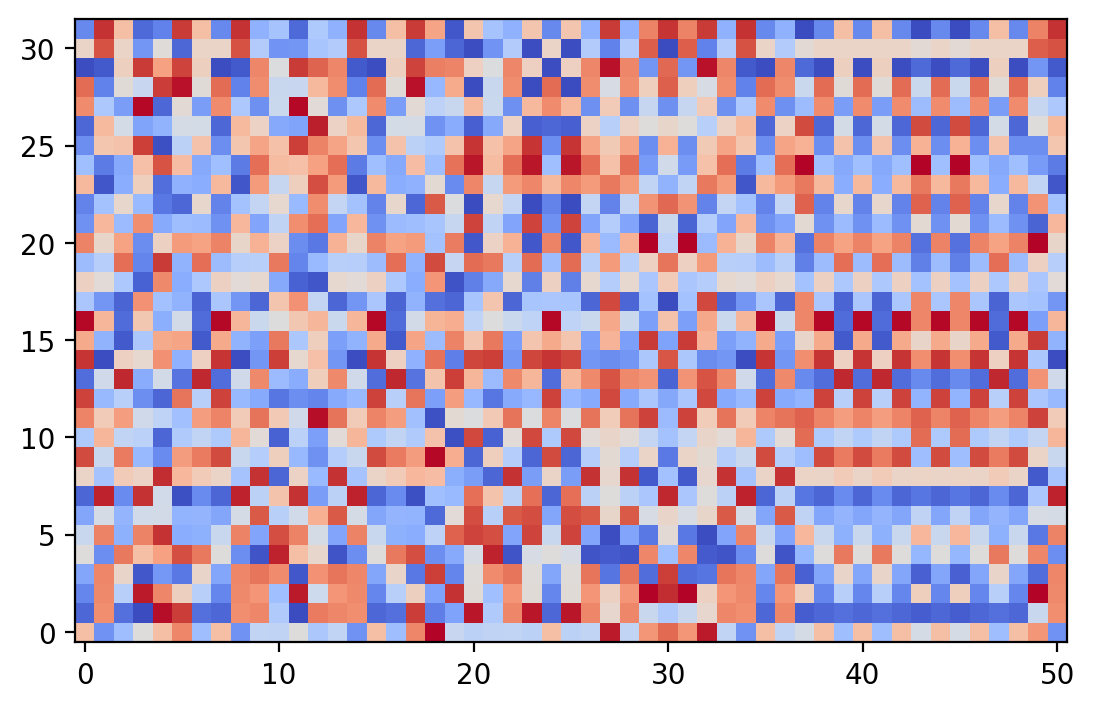

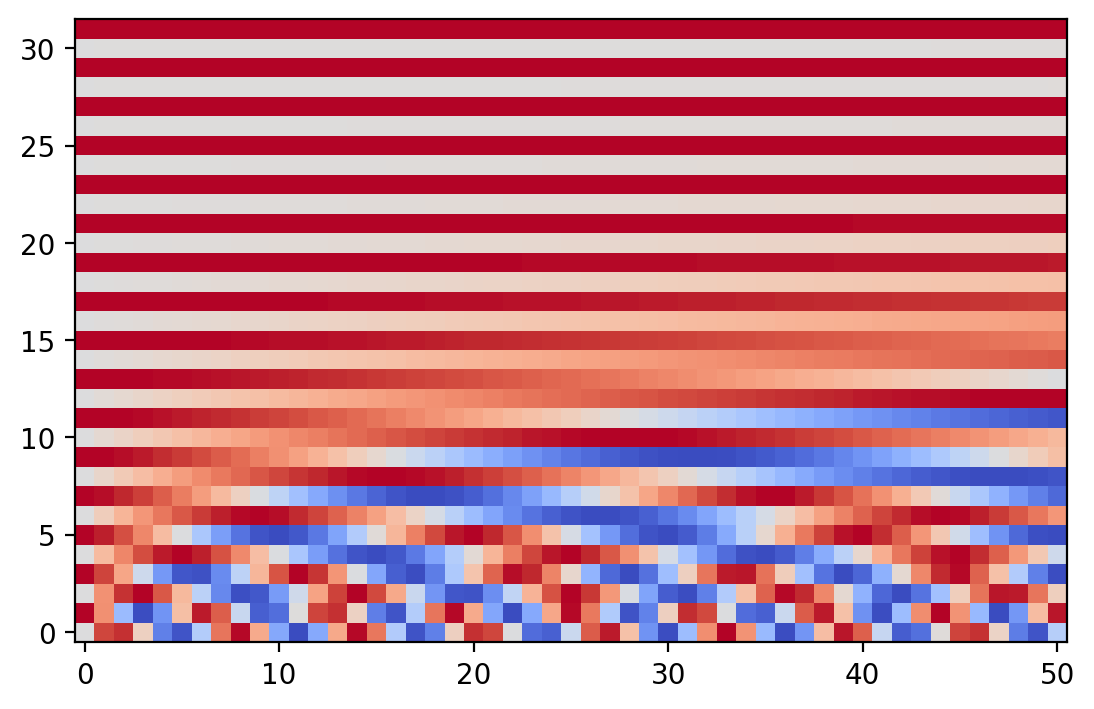

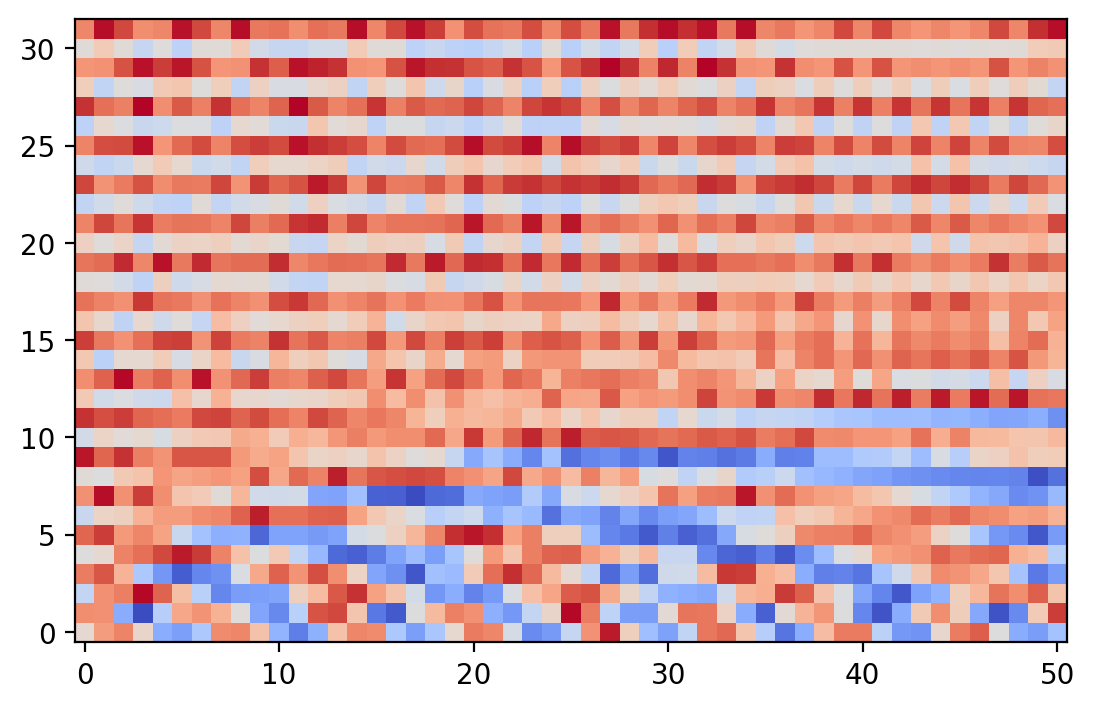

In [22]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [23]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          7,552 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          3,072 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 59)       │         15,163 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 24)       │          6,168 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,479,379 (5.64 MB)

 Trainable params: 1,479,379 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.weights.h5")
    # model = models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [26]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "./output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [27]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

Epoch 1/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 4.9523

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[['START', 'C4', 'A3', 'E-4', 'D4', 'C4', 'E-4', 'D4', 'D4', 'C4', 'D4', 'C4', 'D4', 'C4', 'B-3', 'C4', 'C4', 'C4', 'D4', 'B3', 'C4', 'B3', 'C4', 'C4', 'D4', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'D4', 'D4', 'C4', 'C4', 'D4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'E-4', 'D4', 'C4', 'B3', 'C4', 'B3', 'C4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


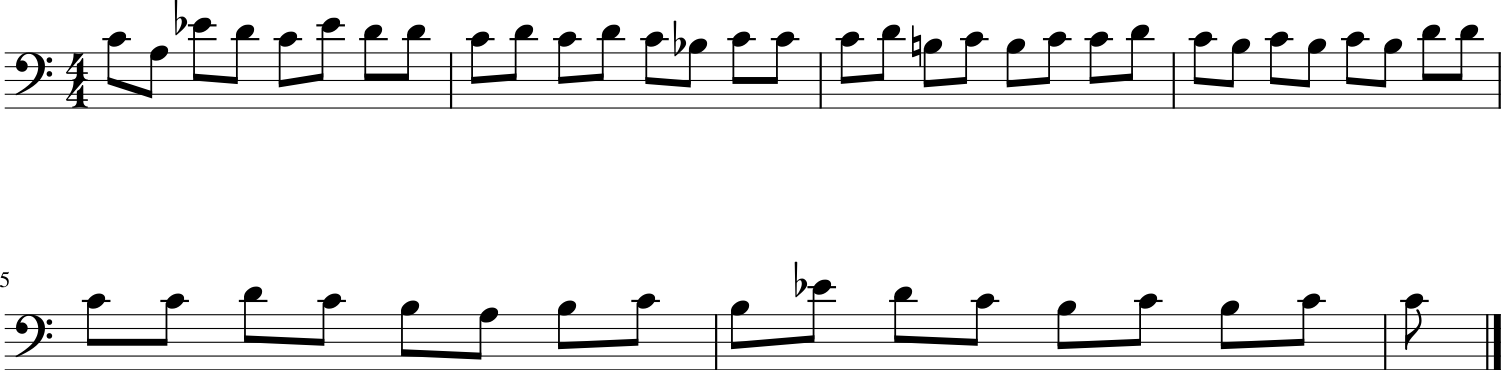

107/107 ━━━━━━━━━━━━━━━━━━━━ 103s 861ms/step - loss: 4.9460
Epoch 2/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.4857[['START', 'C4', 'B-3', 'D4', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F#3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'D3', 'E-3', 'D3', 'C3', 'D3', 'C3', 'B2', 'C3', 'B2', 'D3', 'E-3', 'D3', 'C3', 'D3', 'C3', 'B-2', 'D3', 'C3', 'B-2', 'C3', 'D3', 'C3', 'B-2', 'A2', 'E-2', 'G2', 'B2', 'D3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


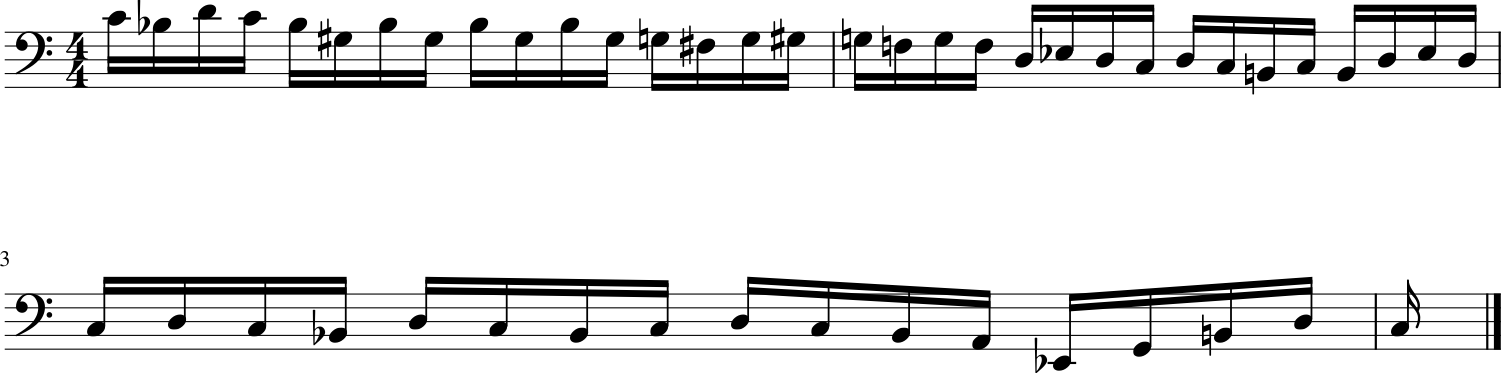

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 359ms/step - loss: 3.4848
Epoch 3/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 3.2737[['START', 'E-:major', '4/4TS', 'G3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'A3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5']]


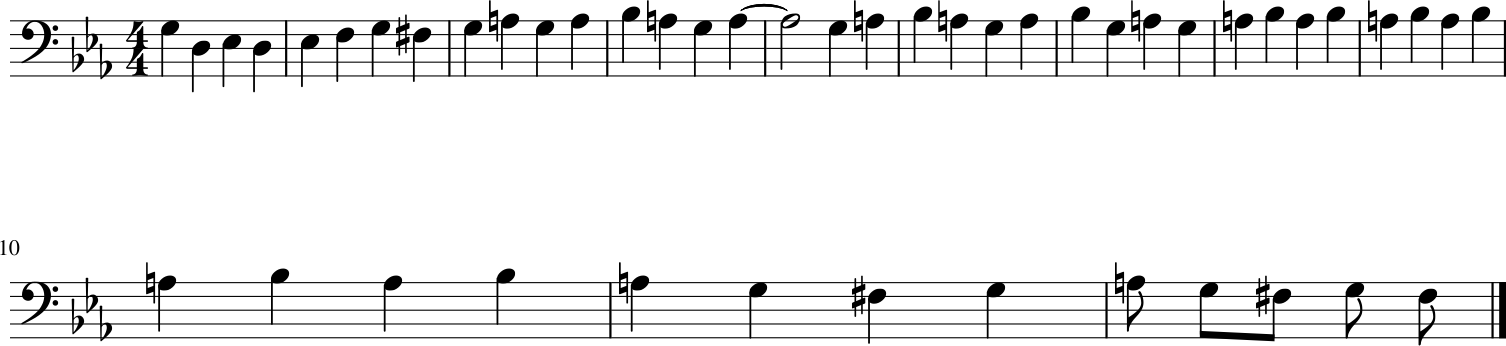

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 359ms/step - loss: 3.2732
Epoch 4/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.0342[['START', 'E-:major', '4/4TS', '3/4TS'], ['0.0', '0.0', '0.0', '0.0']]


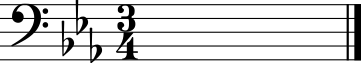

107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 3.0346
Epoch 5/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 3.0130[['START', 'D:major', '4/4TS', 'rest', 'D4', 'E4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'E3', 'F3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'F#3', 'G3', 'F#3', 'F#3', 'F#3', 'F#3', 'G3', 'F#3', 'D3', 'F#3', 'F#3', 'F#3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


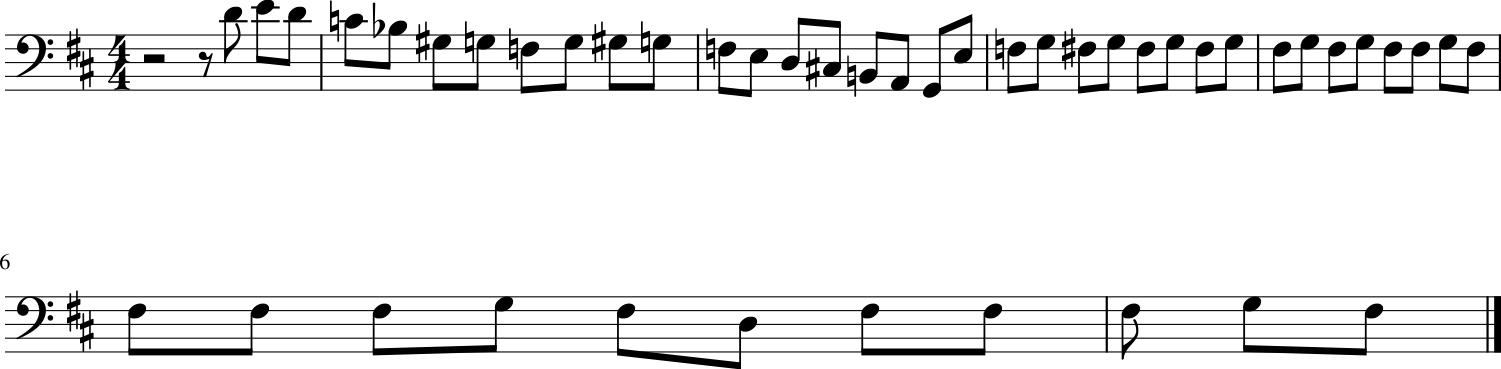

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - loss: 3.0126
Epoch 6/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.8922[['START', 'E-:major', '4/4TS', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'E-3', 'D3', 'C3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'D3'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


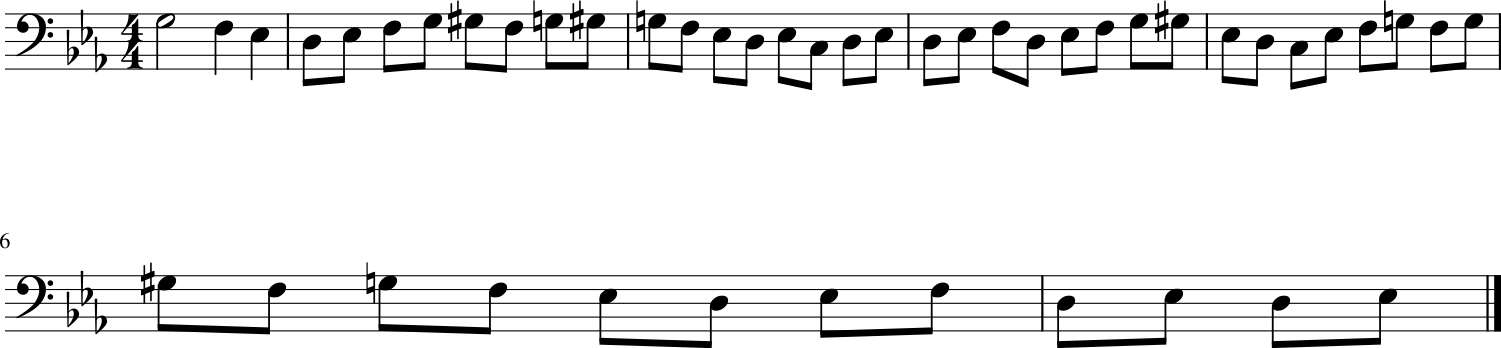

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - loss: 2.8926
Epoch 7/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.9401[['START', 'E-:major', '4/4TS', 'rest', 'D4', 'D4', 'C4', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'G3', 'A3', 'B3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'G3', 'F#3', 'G3', 'F#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


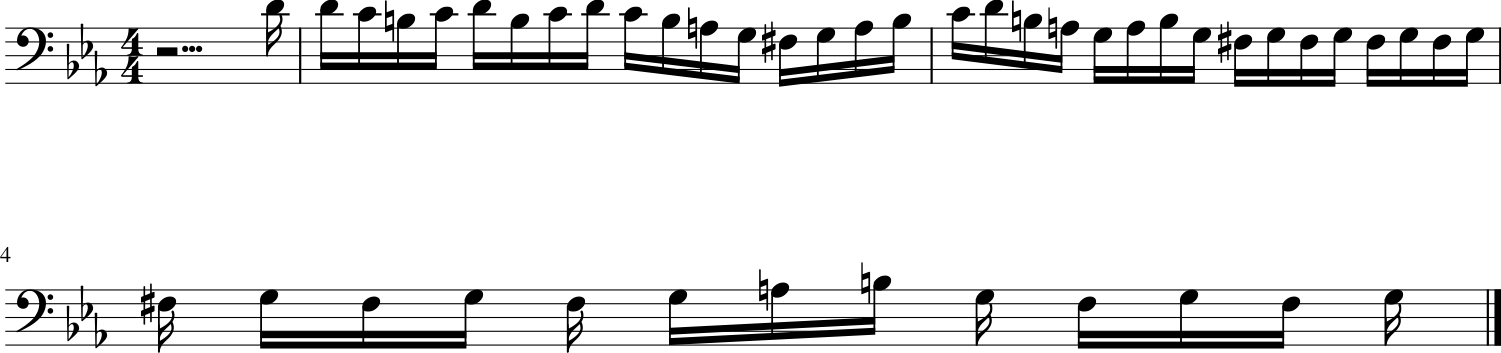

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - loss: 2.9397
Epoch 8/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.8471[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'C4', 'B-3', 'E-4', 'E-4', 'D4', 'C4', 'B-3', 'E-4', 'C4', 'B-3', 'E-4', 'C4', 'B-3', 'E-4', 'E-4', 'E-4', 'C4', 'B-3', 'E-4', 'D4', 'C4', 'E-4', 'D4', 'E-4', 'E-4', 'C4', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'G#3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


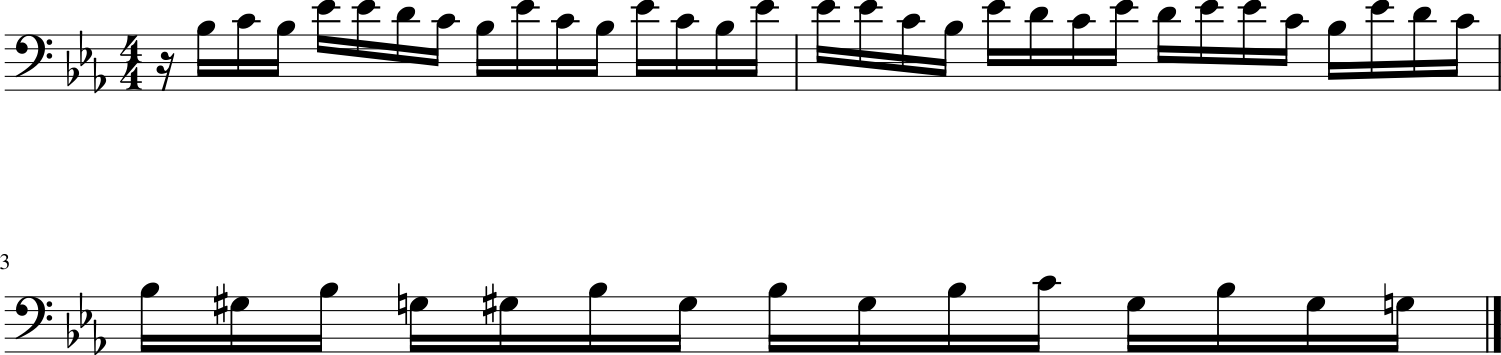

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 359ms/step - loss: 2.8472
Epoch 9/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.8613[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


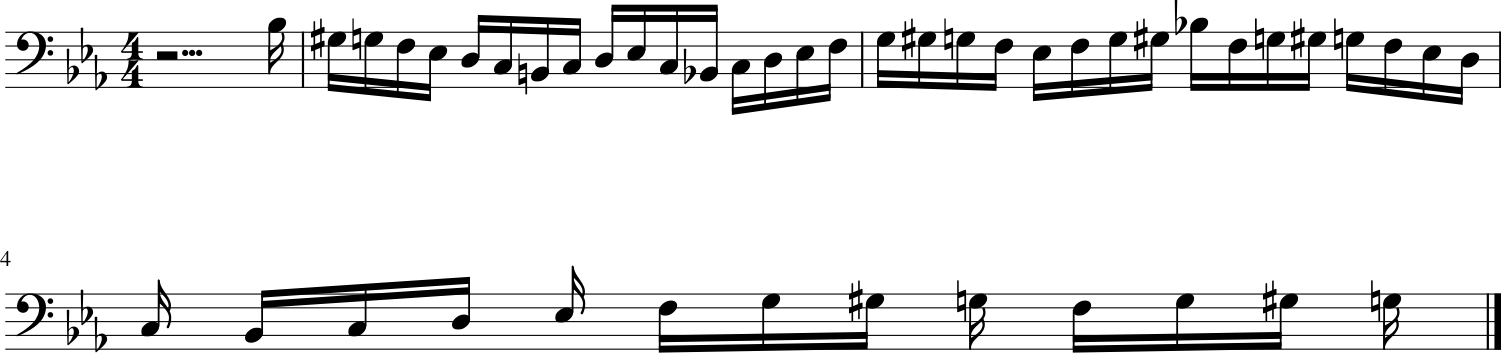

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 359ms/step - loss: 2.8609
Epoch 10/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.7254[['START', 'E-:major', '4/4TS', 'C3', 'B-2', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'B-2', 'D3', 'E-3', 'B-2', 'G#2', 'B-2', 'E-2', 'G#3', 'B-3', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '3.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


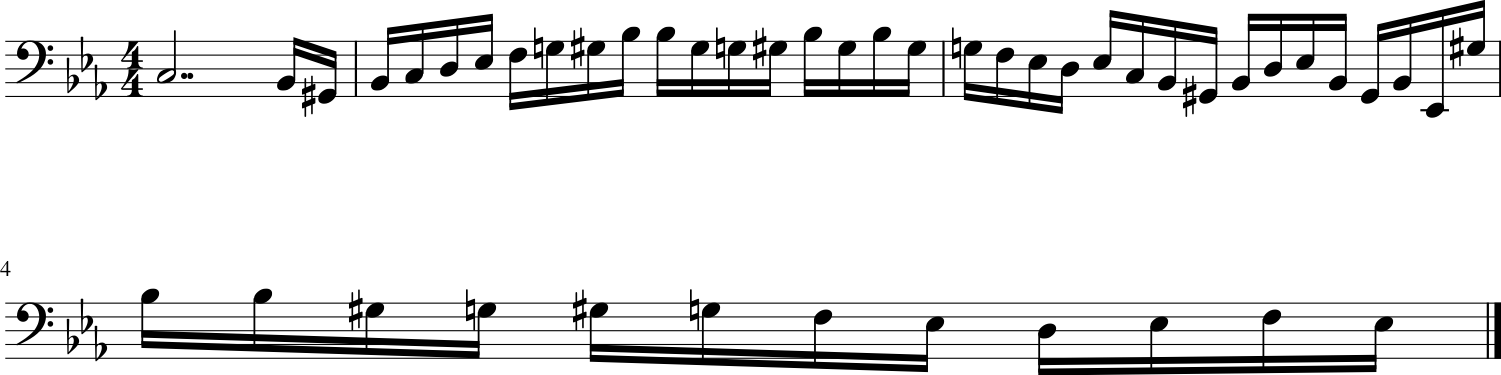

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 367ms/step - loss: 2.7257
Epoch 11/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.7233[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'D3', 'E-3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


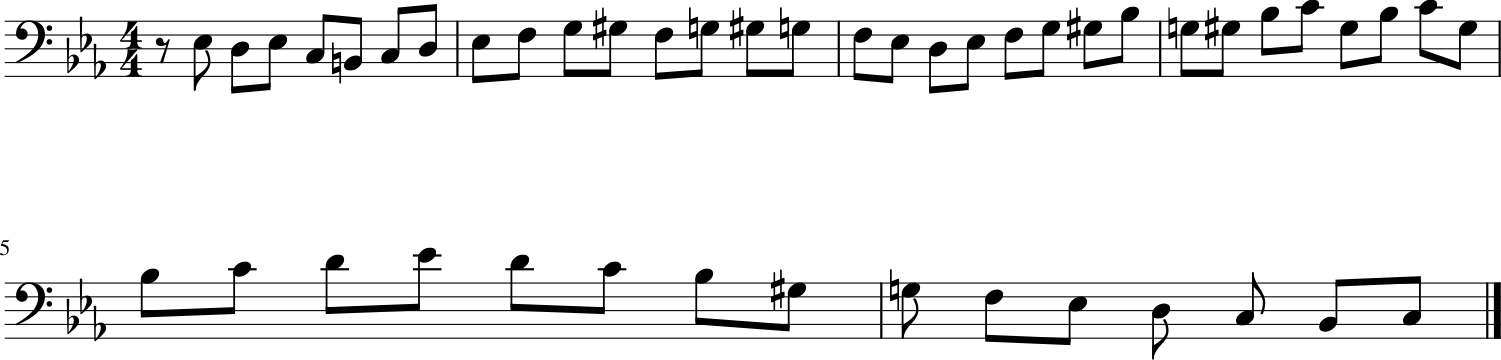

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 361ms/step - loss: 2.7232
Epoch 12/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.6162[['START', 'F:major', '3/4TS', 'rest', 'A3', 'D3', 'F3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'C3', 'B2', 'C3', 'G2', 'E3', 'F3', 'G2', 'E3', 'C3', 'E3', 'A2', 'G2', 'F2', 'E2', 'G2', 'A2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


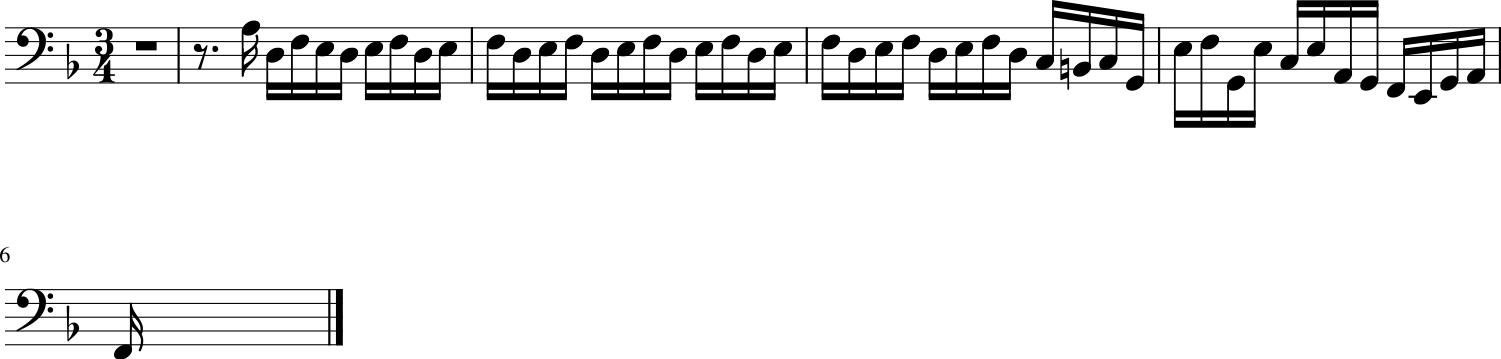

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 361ms/step - loss: 2.6168
Epoch 13/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.6752[['START', 'D:major', '4/4TS', 'rest', 'A3', 'D4', 'A3', 'F#4', 'A3', 'D4', 'A3', 'C#4', 'A3', 'A3', 'A3', 'A3', 'A3', 'A4', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


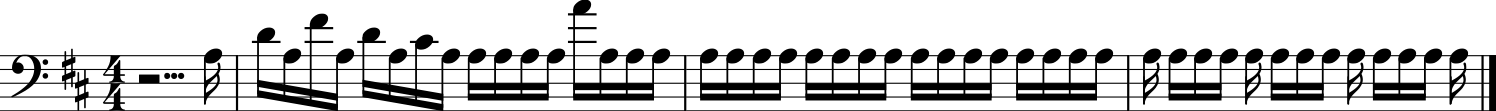

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 360ms/step - loss: 2.6751
Epoch 14/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.6330[['START', 'E-:major', '4/4TS', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'E-3', 'E-3', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


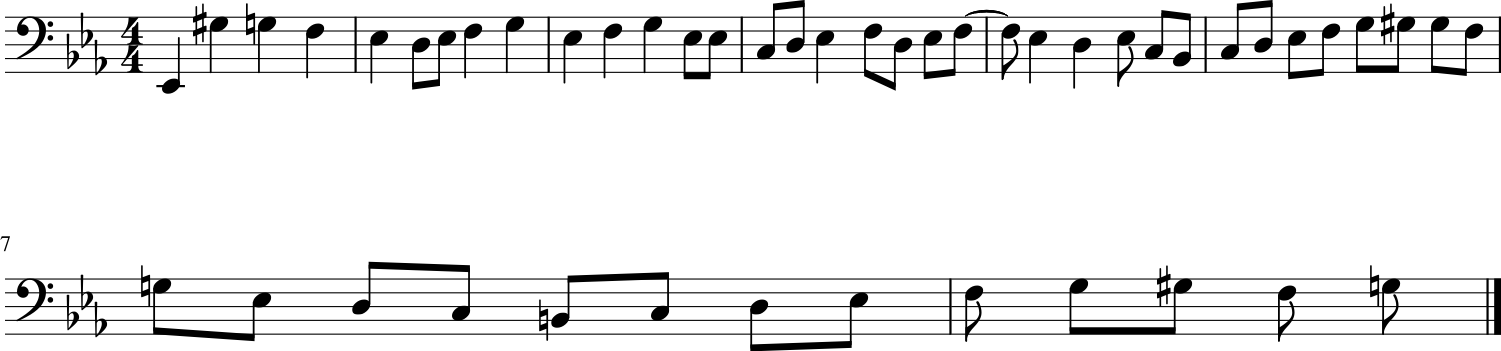

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 374ms/step - loss: 2.6331
Epoch 15/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.6597[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


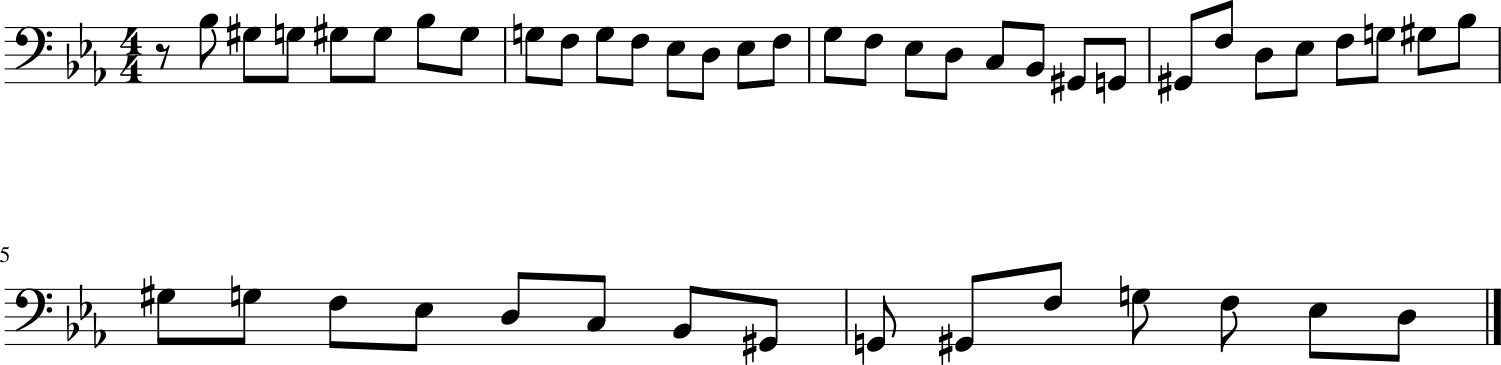

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 367ms/step - loss: 2.6594
Epoch 16/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.5550[['START', 'G:major', '4/4TS', 'rest', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G#3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G#3', 'A3', 'B3', 'A3', 'E3', 'B3', 'A3', 'G#3', 'F#3', 'G#3', 'A3', 'B3', 'G#3', 'E3', 'E4', 'E4', 'E3', 'A3', 'B3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'E4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


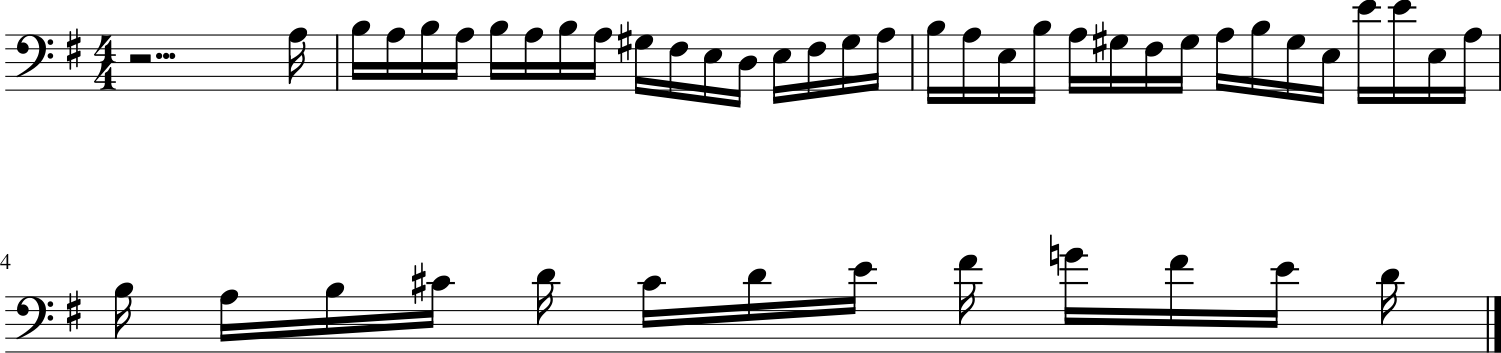

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 362ms/step - loss: 2.5554
Epoch 17/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.5691[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'D4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'F#4', 'A4', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4'], ['0.0', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


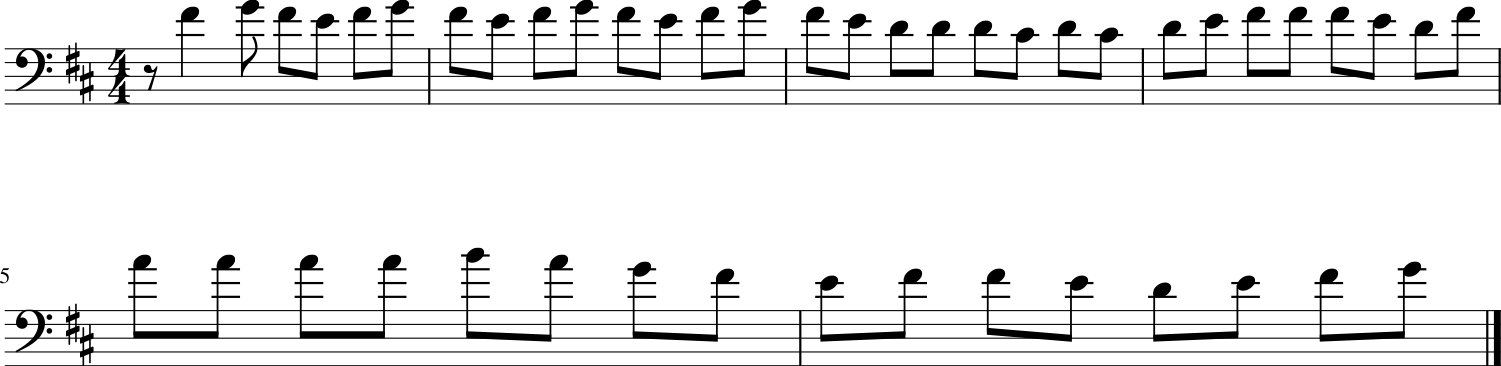

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 363ms/step - loss: 2.5691
Epoch 18/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.4695[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'C3', 'G#2', 'G2', 'G#2', 'E-3', 'C3', 'D3', 'E-3', 'C3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G#2', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '0.0', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3']]


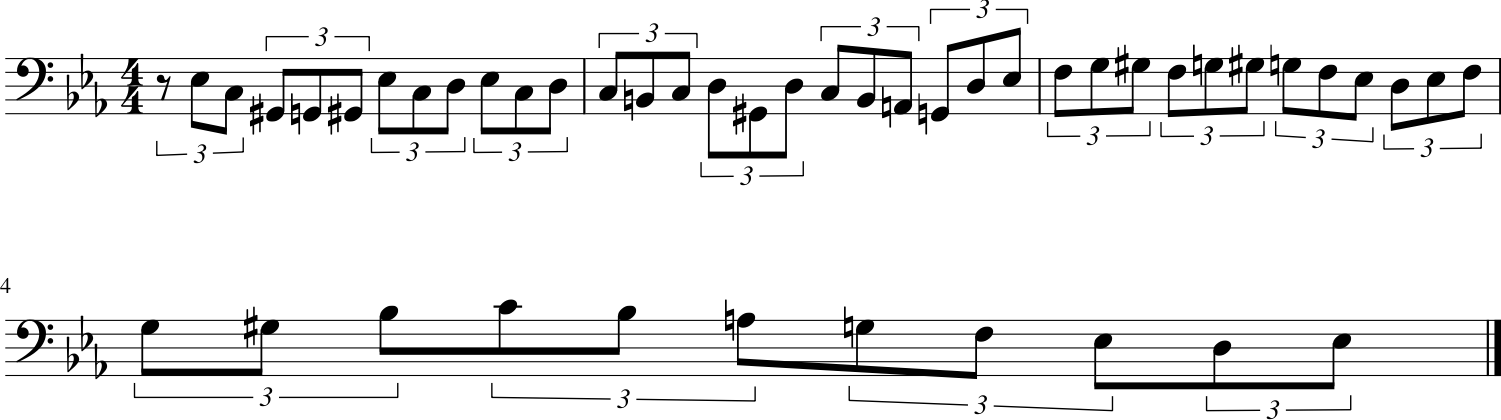

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 366ms/step - loss: 2.4702
Epoch 19/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.4931[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'C4', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G3', 'F3', 'G3'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


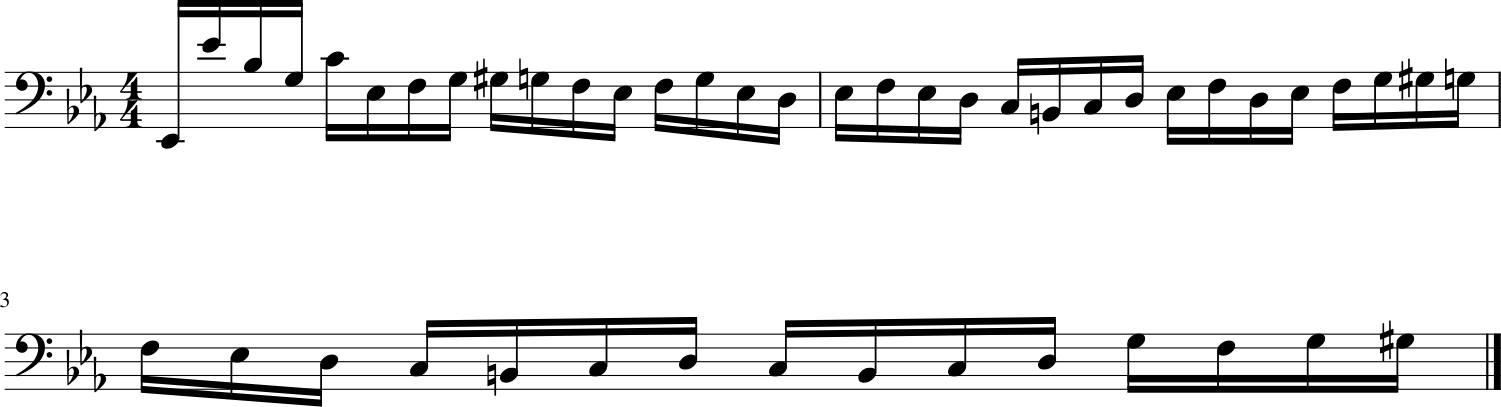

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 360ms/step - loss: 2.4934
Epoch 20/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.4344[['START', 'E-:major', '4/4TS', 'E-2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'G2', 'G#2', 'B-2', 'G2', 'G#2', 'B-2', 'C3', 'E-2', 'G2', 'B-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


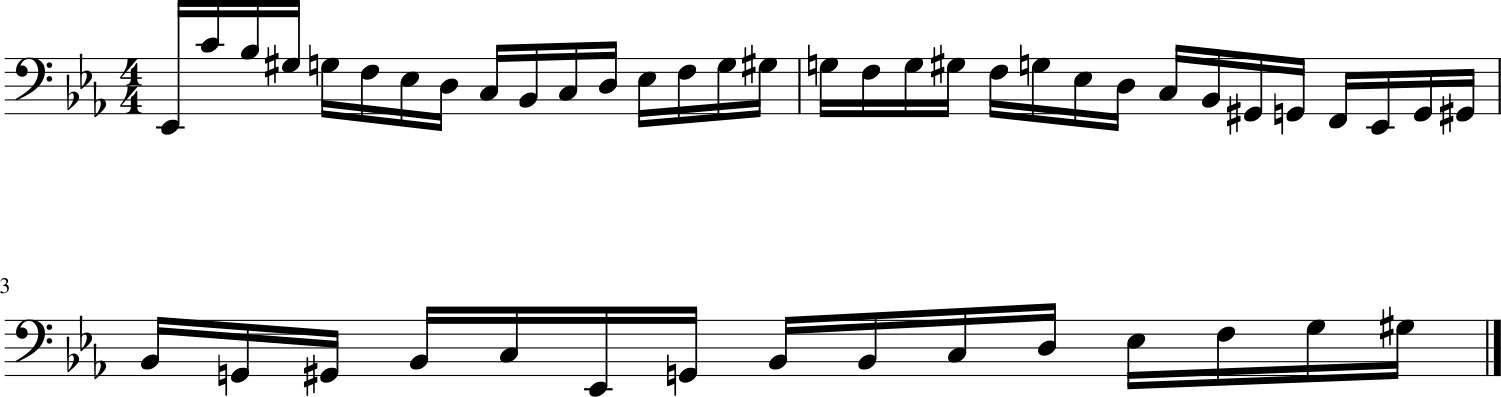

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 359ms/step - loss: 2.4348
Epoch 21/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.4835[['START', 'E-:major', '4/4TS', 'E-2', 'C4', 'G#3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'B-2', 'D3', 'E-3', 'E-2', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'C4', 'G#3', 'B-3', 'C4', 'E-3', 'G#3'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


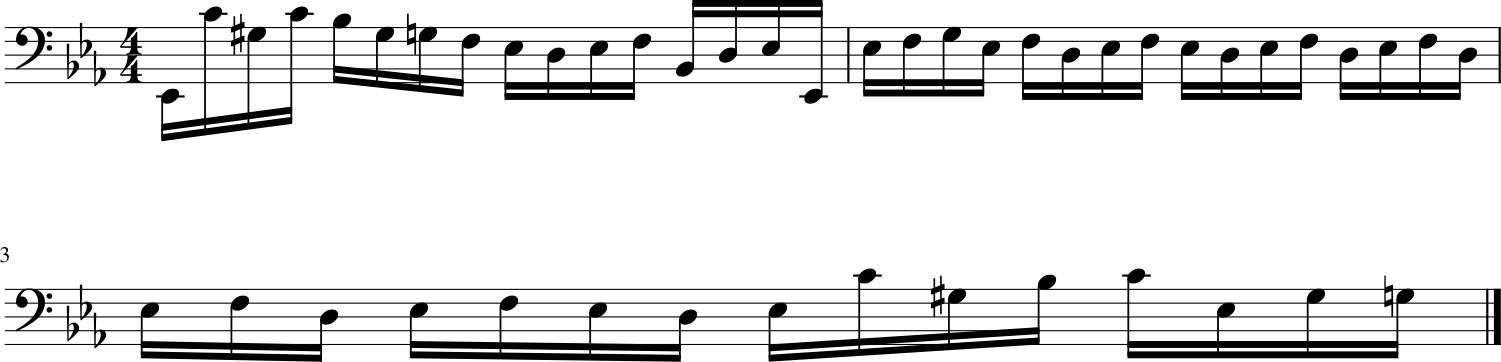

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 370ms/step - loss: 2.4832
Epoch 22/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.3295[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G3', 'F3', 'E-3', 'B-2', 'G#2', 'G2', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'E-2', 'G3', 'F3', 'E-3', 'D3', 'F3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'C3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


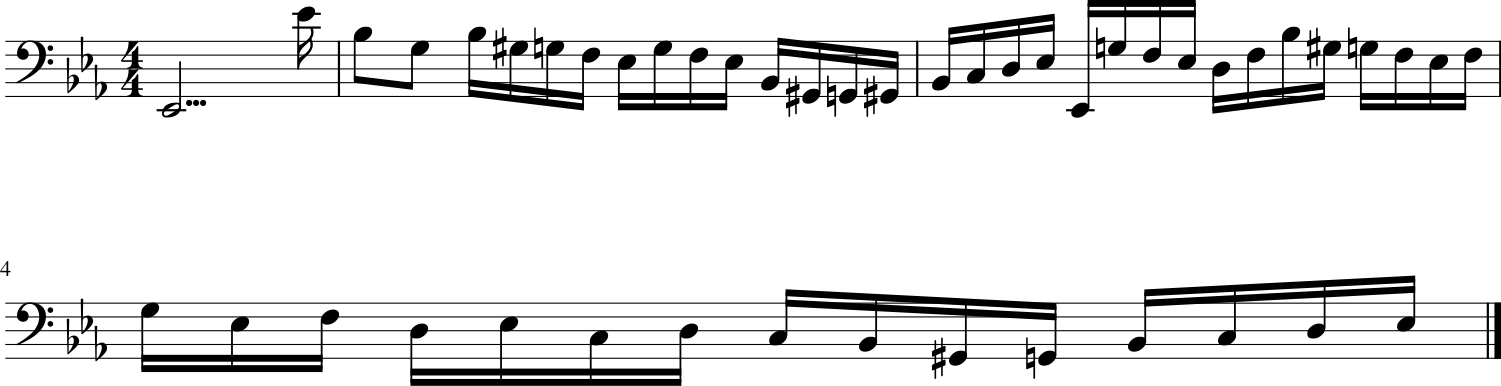

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 362ms/step - loss: 2.3303
Epoch 23/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.4003[['START', 'E-:major', '3/4TS', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


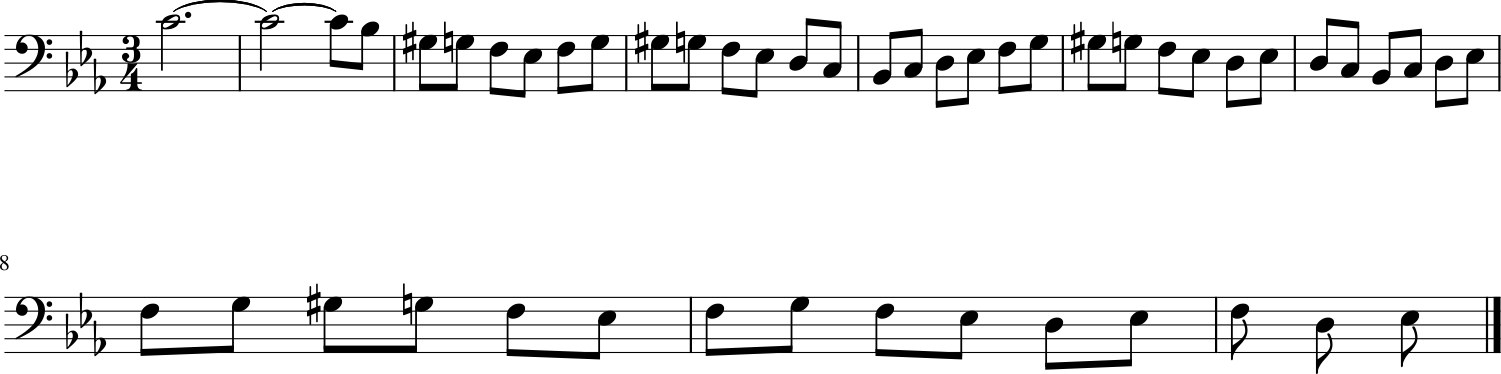

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 365ms/step - loss: 2.4004
Epoch 24/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.3324[['START', 'D:major', '3/4TS', 'rest', 'D4', 'D4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'A3', 'C#4', 'E4', 'E4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'G#4', 'A4', 'A4', 'G#4', 'A4', 'A4', 'A4', 'G#4', 'A4', 'A4', 'A4', 'G#4', 'A4', 'A4', 'D4', 'C#4', 'A4', 'A4', 'F#4', 'C#4', 'A4', 'G4', 'F#4', 'E4', 'F#4'], ['0.0', '3.75', '0.25', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3']]


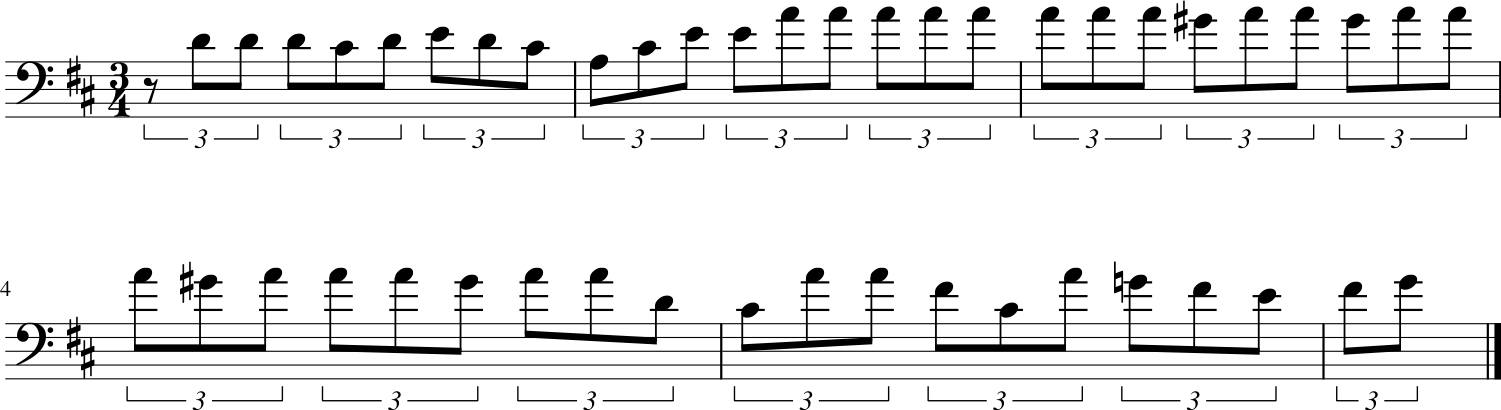

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 357ms/step - loss: 2.3331
Epoch 25/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.3394[['START', 'F:major', '3/4TS', 'B-3', 'A3', 'B-3', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


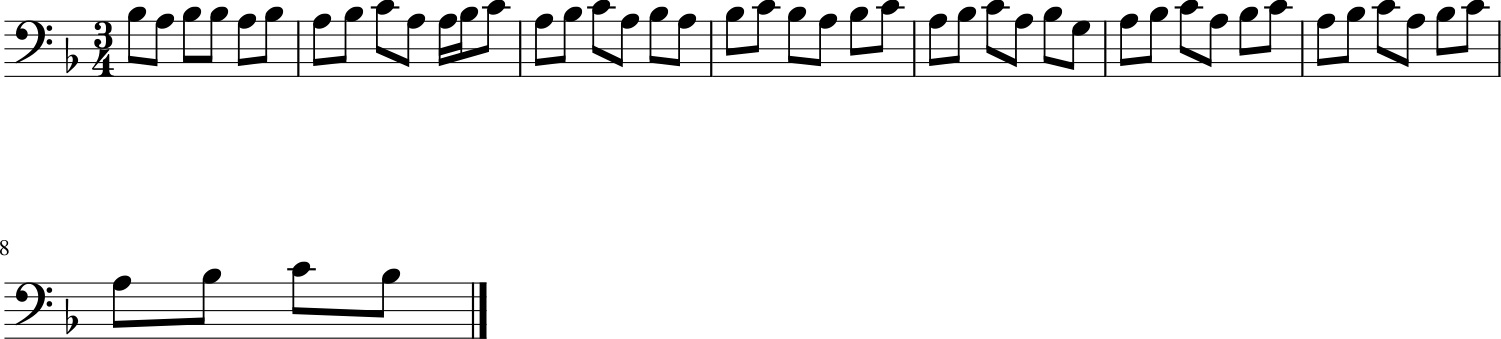

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 357ms/step - loss: 2.3396
Epoch 26/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.3338[['START', 'E-:major', '3/8TS', 'rest', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'G2', 'B-2', 'C3', 'G#2', 'B-2', 'C3', 'G#2', 'C3', 'F3', 'G#2', 'B-2'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5']]


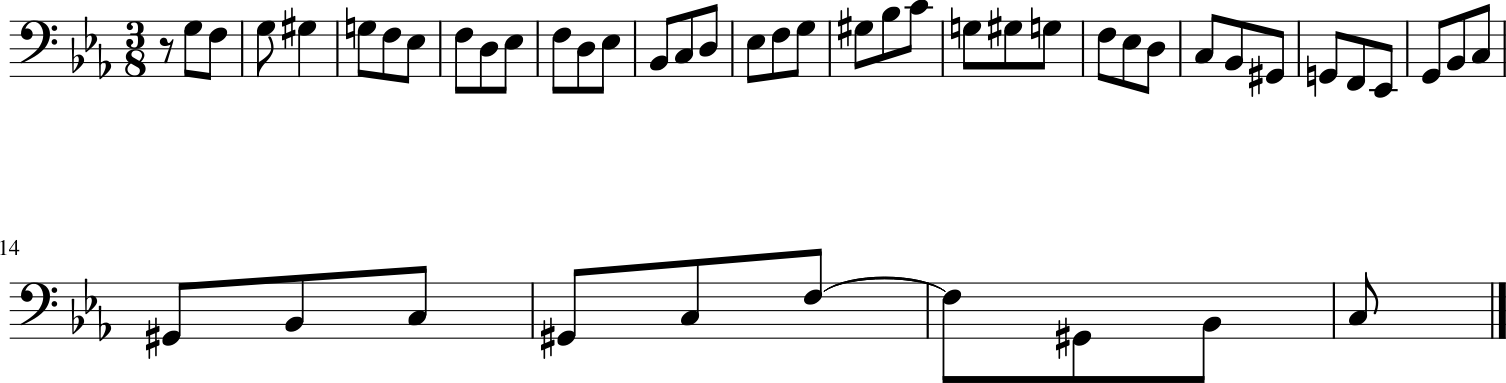

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - loss: 2.3340
Epoch 27/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.3052[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


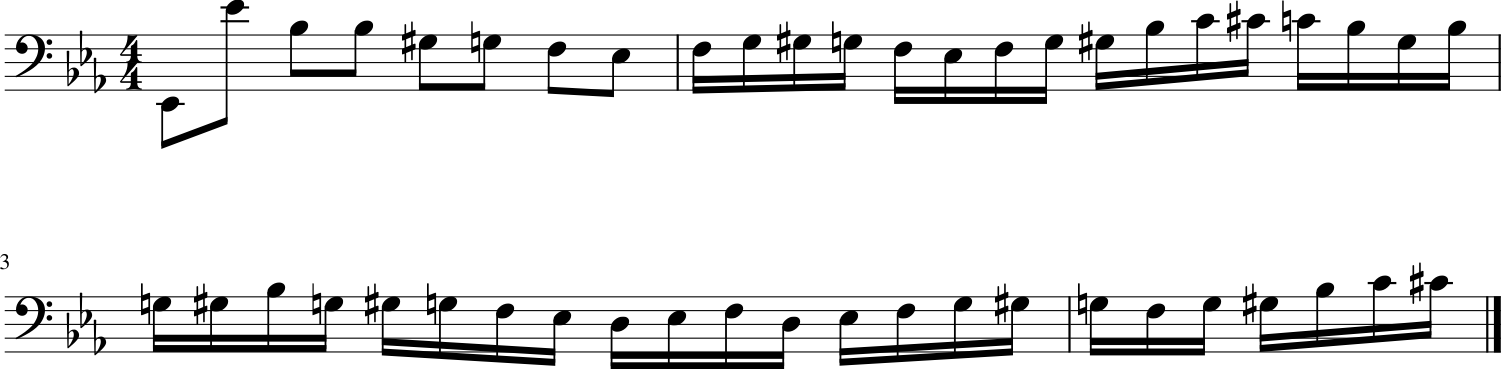

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 360ms/step - loss: 2.3054
Epoch 28/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.2615[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'E-3', 'B-3', 'F3', 'G3', 'E-3', 'B-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'A3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


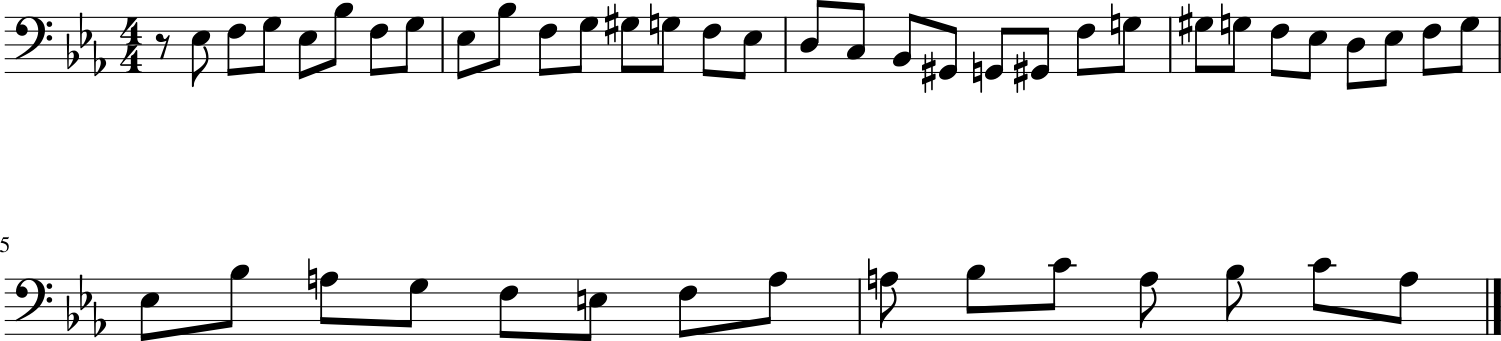

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 373ms/step - loss: 2.2619
Epoch 29/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.2710[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


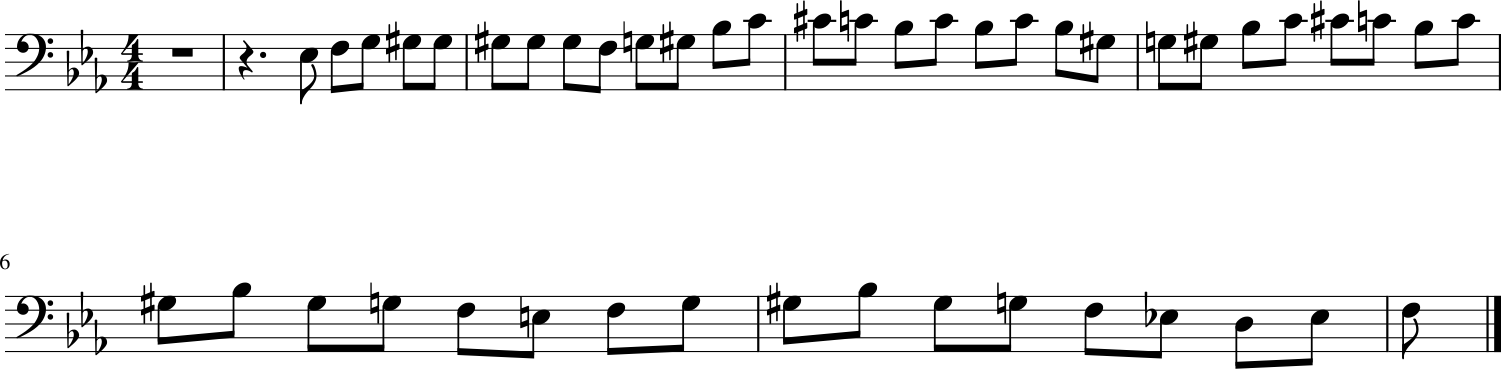

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 362ms/step - loss: 2.2711
Epoch 30/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.2643[['START', 'E-:major', '4/4TS', 'rest', 'C3', 'C3', 'G#2', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F3', 'B-2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'F3', 'B-3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '2.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


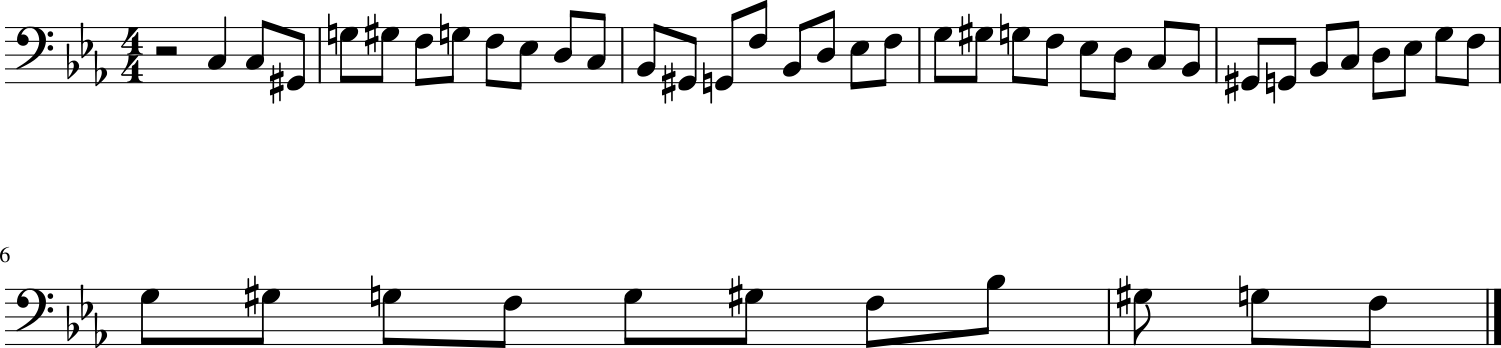

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 363ms/step - loss: 2.2642
Epoch 31/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.2508[['START', 'F:major', '4/4TS', 'E-2', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'F2', 'G2', 'G3', 'E-2', 'D2', 'E-2', 'F2', 'G2', 'G#2', 'B-2', 'C3', 'E-2', 'D2', 'E-2', 'G3', 'F3', 'E-2', 'G3', 'F3', 'B-2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


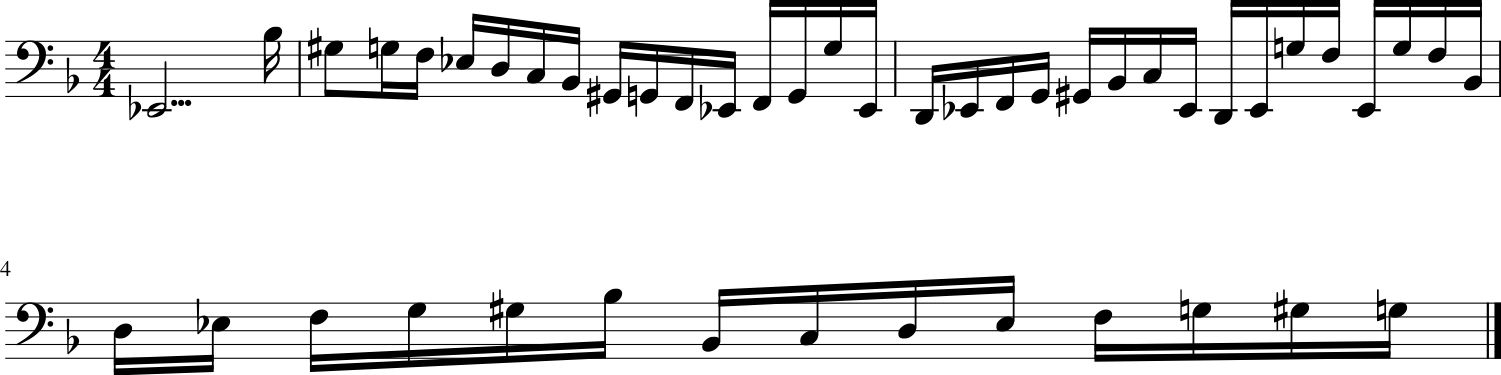

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - loss: 2.2509
Epoch 32/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.1464[['START', 'G:major', '4/4TS', 'rest', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'B2', 'G2', 'D3', 'E2', 'B2', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'D3', 'G3', 'A3', 'B3', 'C4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


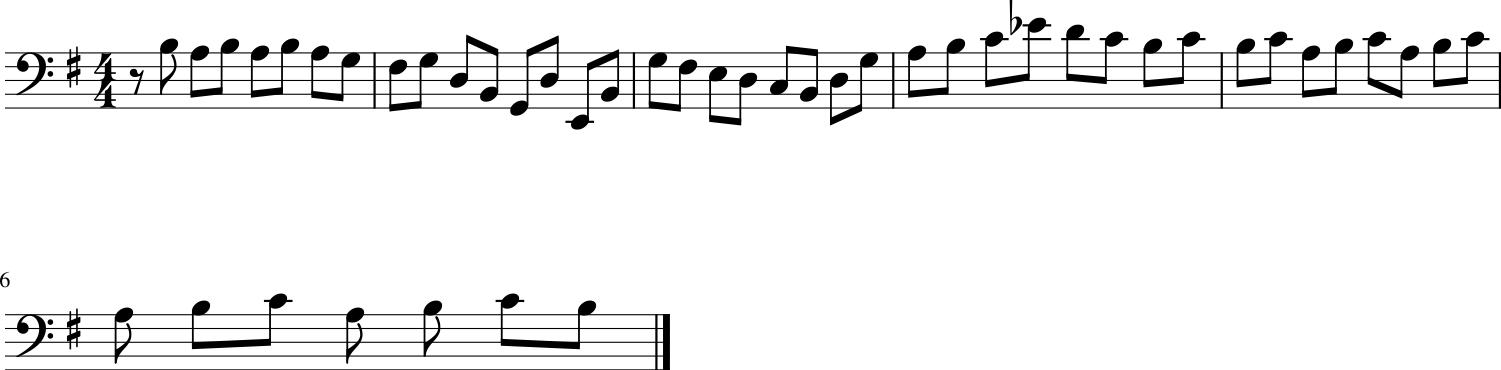

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 365ms/step - loss: 2.1471
Epoch 33/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.1865[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'C3', 'G2', 'G#2', 'F2', 'G#2', 'D3', 'F3', 'G#3', 'C3', 'B2', 'D3'], ['0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


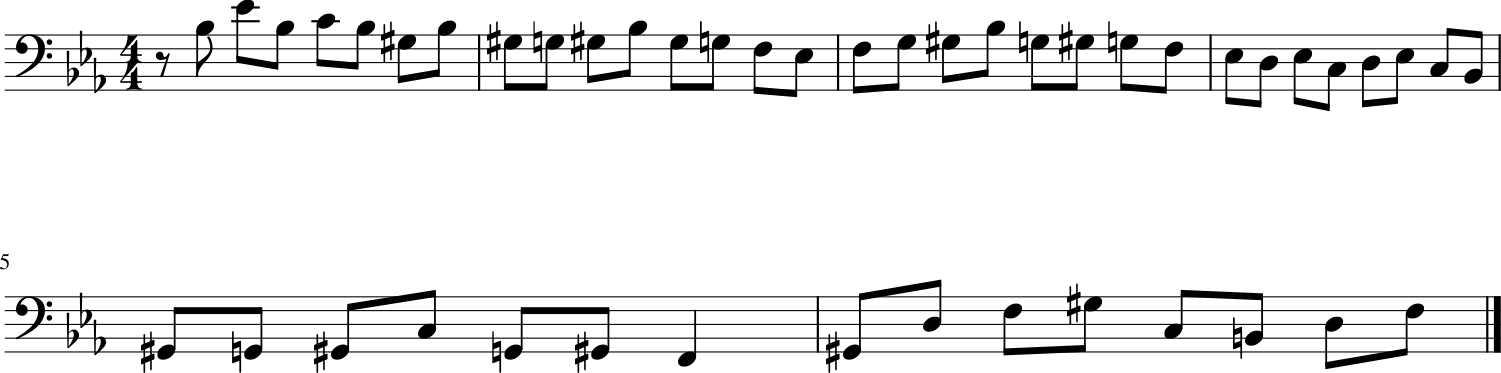

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 362ms/step - loss: 2.1867
Epoch 34/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.2062[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#2', 'F2', 'D3', 'F2', 'B2', 'D3', 'D3', 'B2', 'D3', 'F3', 'G2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'E-3', 'G3', 'C4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


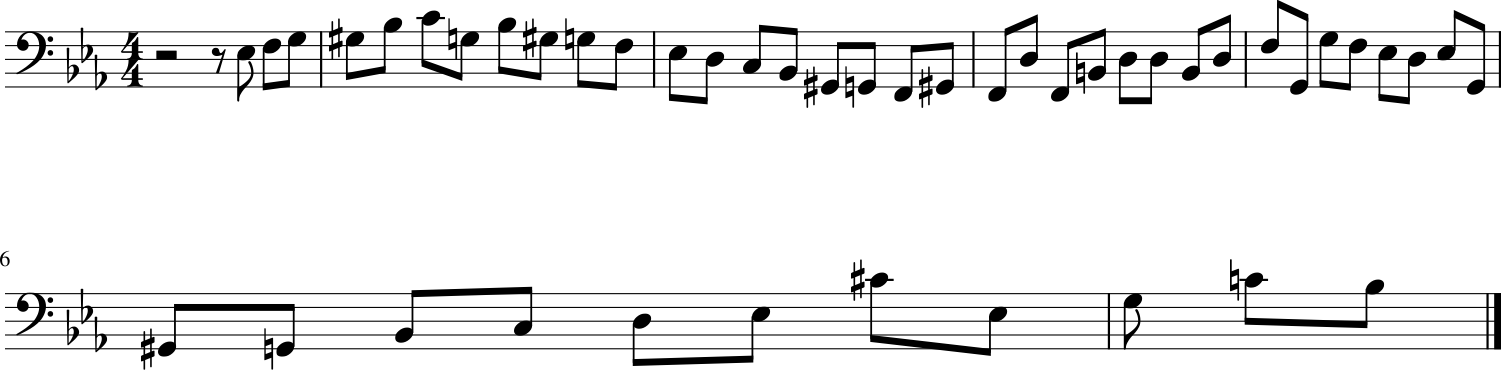

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 366ms/step - loss: 2.2061
Epoch 35/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.1342[['START', 'D:major', '3/4TS', 'rest', 'D4', 'D4', 'D3', 'F#3', 'A3', 'G3', 'F#3', 'G3', 'B2', 'G3', 'D3', 'B2', 'D3', 'B2', 'G2', 'B2', 'D3', 'G2', 'D3', 'G3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'C#4', 'B3', 'A3', 'D4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4'], ['0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


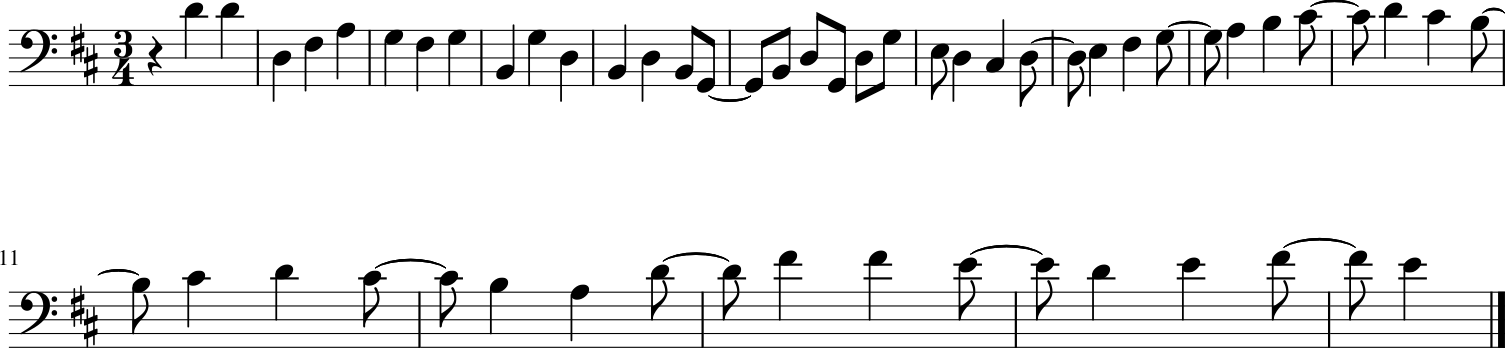

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 372ms/step - loss: 2.1344
Epoch 36/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.1269[['START', 'E-:major', '3/4TS', 'B-3', 'C4', 'C#4', 'C#4', 'C#4', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'B-3', 'G3', 'G#3', 'C4', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


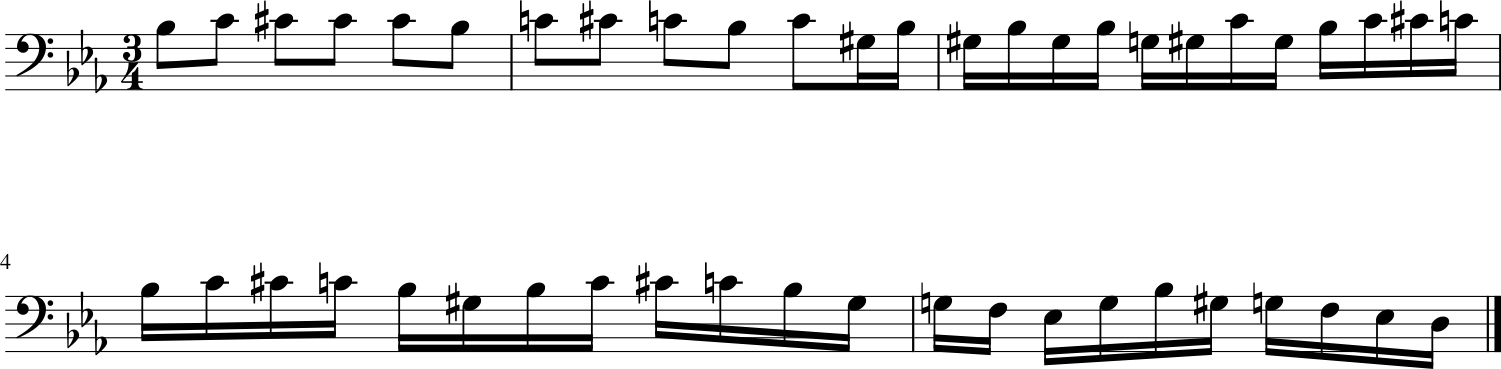

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 366ms/step - loss: 2.1269
Epoch 37/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.0721[['START', 'F:major', '3/4TS', 'rest', 'D4', 'D4', 'rest', 'A3', 'D4', 'rest', 'F#3', 'rest', 'A3', 'D4', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'rest', 'rest', 'D4', 'rest', 'rest'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


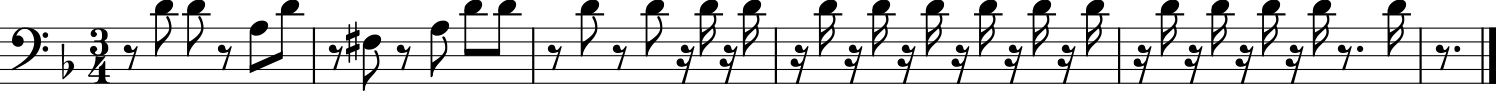

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - loss: 2.0726
Epoch 38/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.9975[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


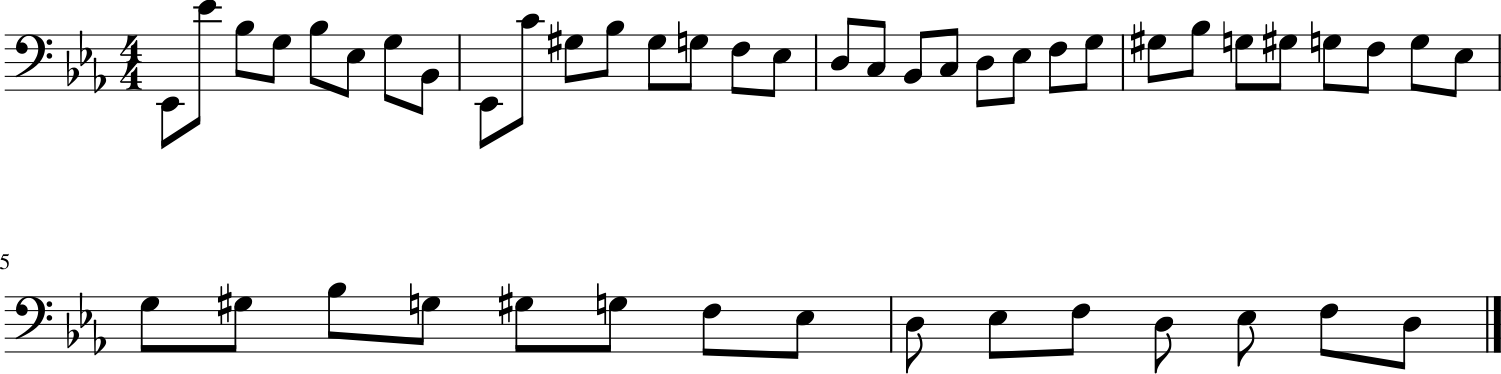

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - loss: 1.9987
Epoch 39/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.0754[['START', 'G:major', '4/4TS', 'rest', 'D3', 'G2', 'D3', 'D3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'E3', 'F3', 'D3', 'E3', 'C3', 'G2', 'D3', 'E3', 'F3', 'G3', 'E3', 'C3', 'G2', 'G3', 'A3', 'D3', 'E3', 'F3', 'D3', 'E3', 'A2', 'C4', 'C4', 'C4', 'D4', 'C4', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


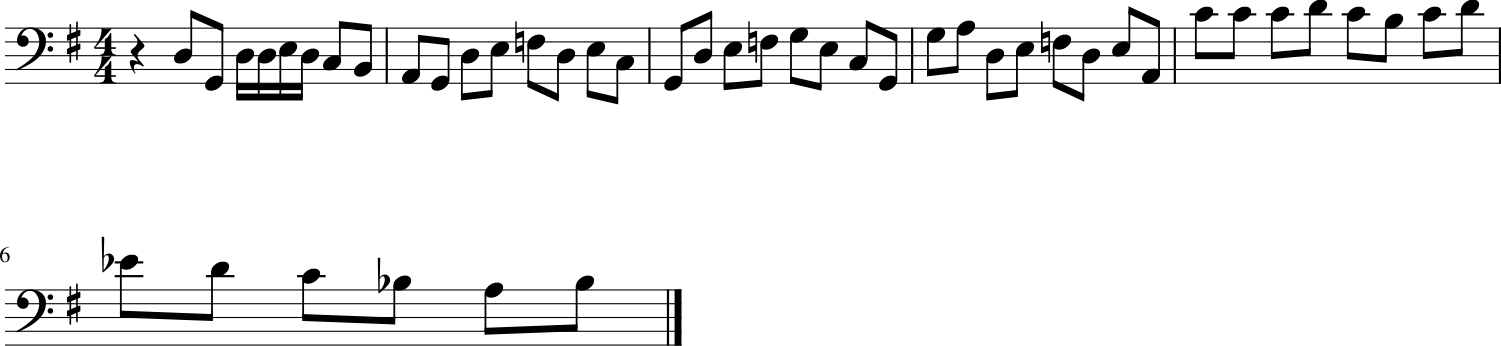

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - loss: 2.0755
Epoch 40/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.0873[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G3', 'B-3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


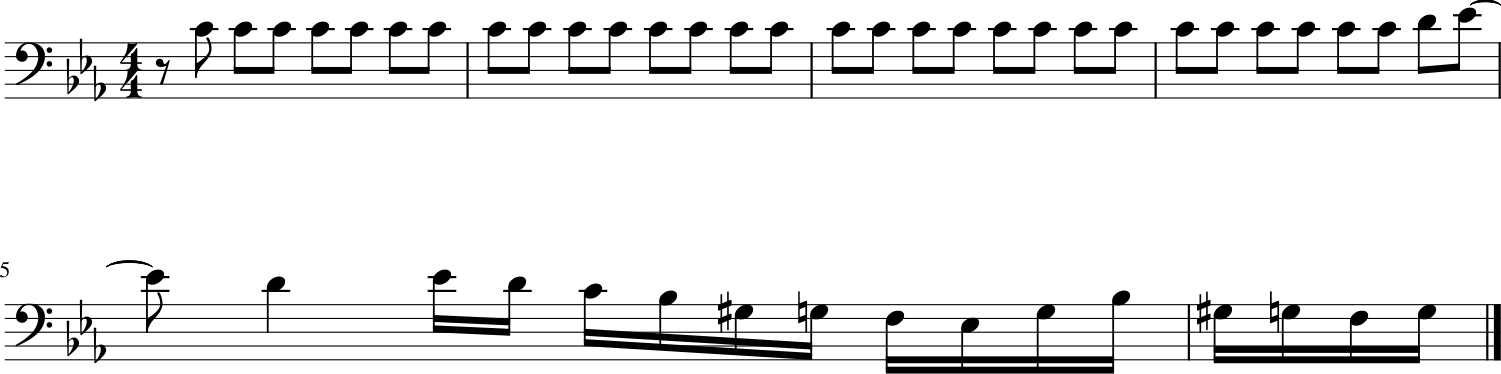

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 359ms/step - loss: 2.0873
Epoch 41/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.0720[['START', 'E-:major', '4/4TS', '3/8TS', 'G3', 'G#3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'C#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3'], ['0.0', '0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


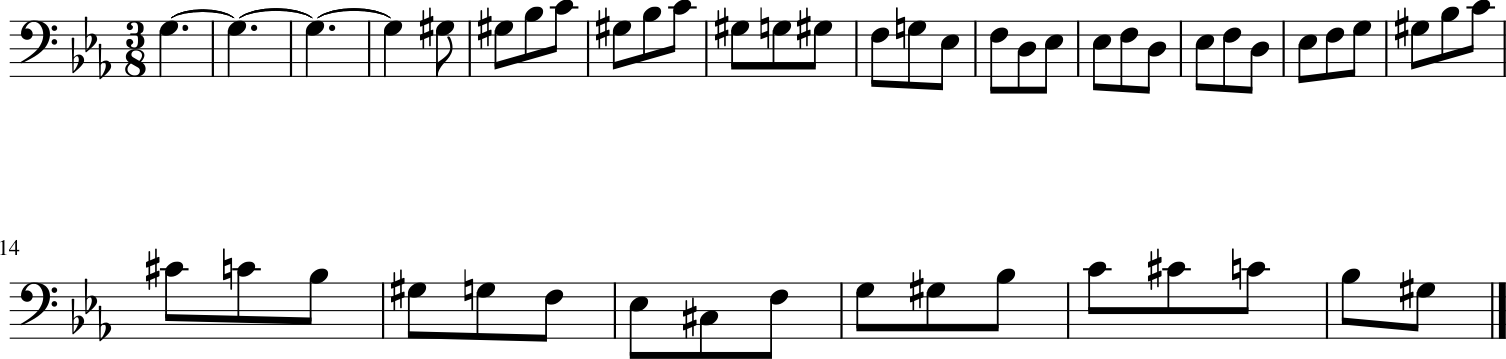

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - loss: 2.0719
Epoch 42/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.0113[['START', 'E-:major', '4/4TS', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'B-2', 'G2', 'B-2', 'E-3', 'G#2', 'G#2', 'F3', 'G3', 'G#3', 'E3', 'B-3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


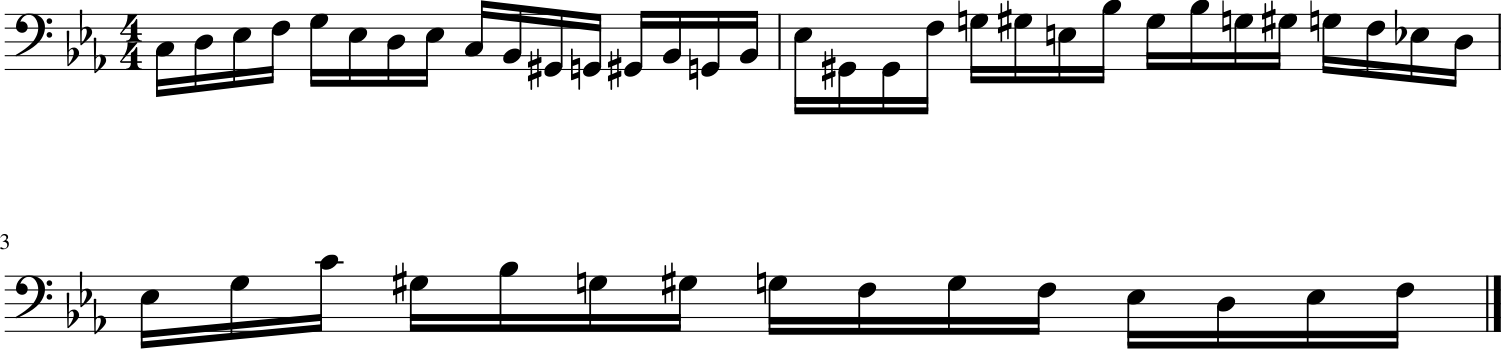

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 361ms/step - loss: 2.0115
Epoch 43/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.0025[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C#4', 'C#4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


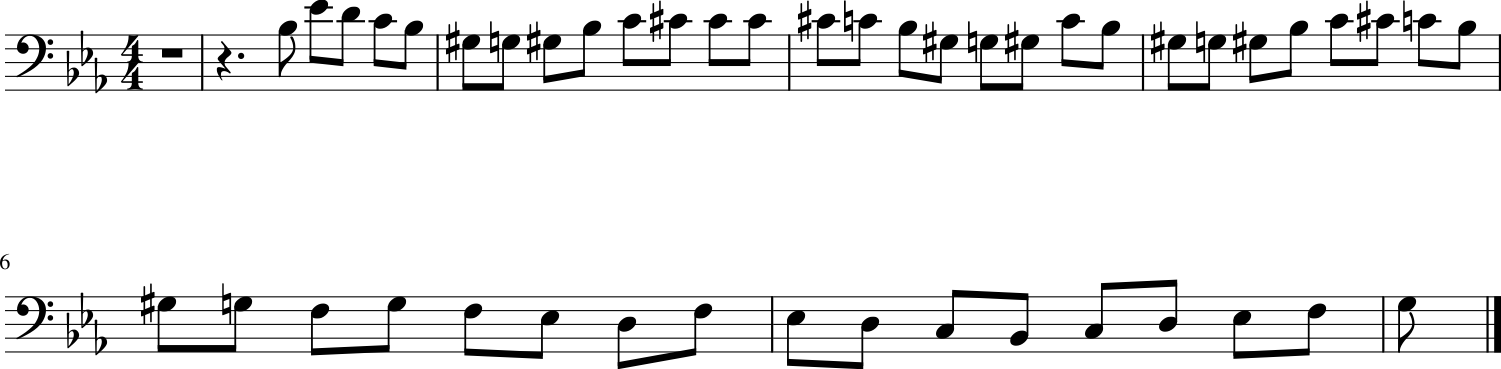

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - loss: 2.0027
Epoch 44/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.9836[['START', 'F:major', '3/4TS', 'A3', 'B-3', 'B-3', 'A3', 'B-3', 'B-3', 'A3', 'G3', 'A3', 'B-3', 'D4', 'C#4', 'D4', 'F3', 'A3', 'D3', 'F3', 'A3', 'B-3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'B-3', 'G3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'G3', 'B-3', 'A3', 'G3', 'F#3', 'E3', 'D3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


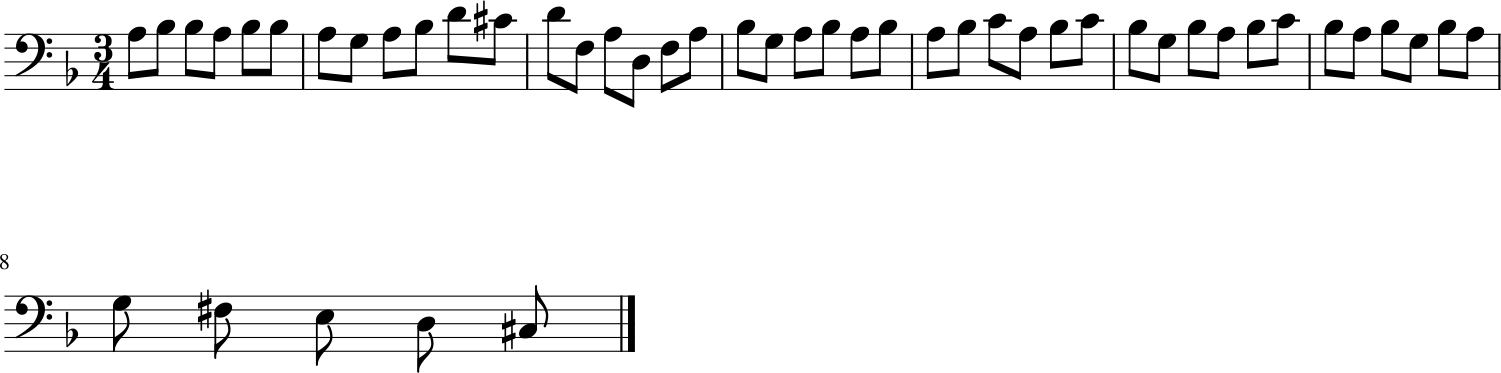

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 365ms/step - loss: 1.9837
Epoch 45/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.9147[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'A3', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'G#4', 'A4', 'A4', 'A4', 'B4', 'C#4', 'A4', 'A4', 'A4', 'B4', 'A4', 'F#4', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'A4', 'G4'], ['0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


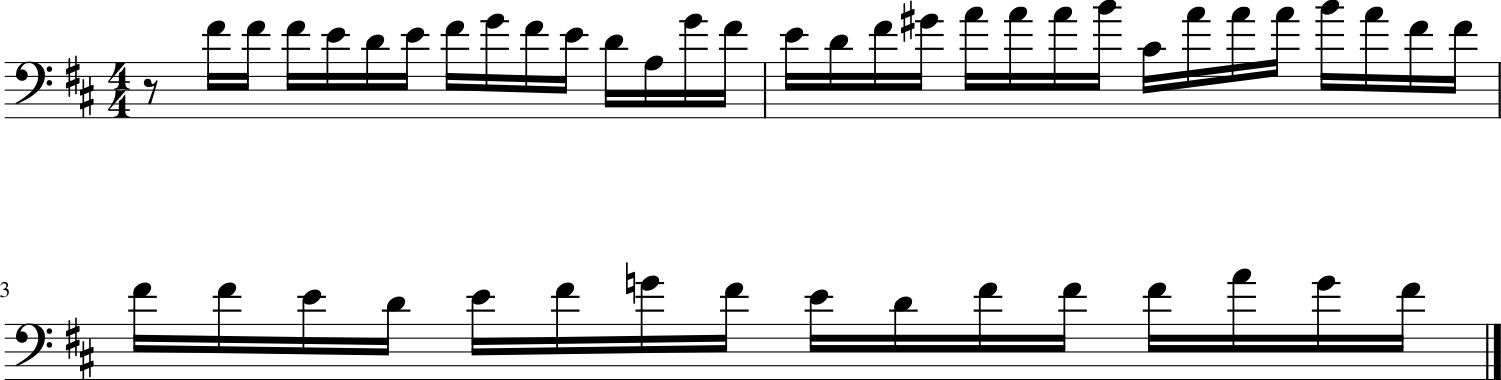

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - loss: 1.9154
Epoch 46/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.9956[['START', 'F:major', '3/4TS', 'D3', 'D3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'B-3', 'G3', 'F3', 'E3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'F#2', 'A2', 'C3', 'E-3', 'D3', 'C3', 'B-2', 'A2', 'B-2', 'D3', 'G3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'D3', 'G#2', 'A2', 'F#2', 'D2'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


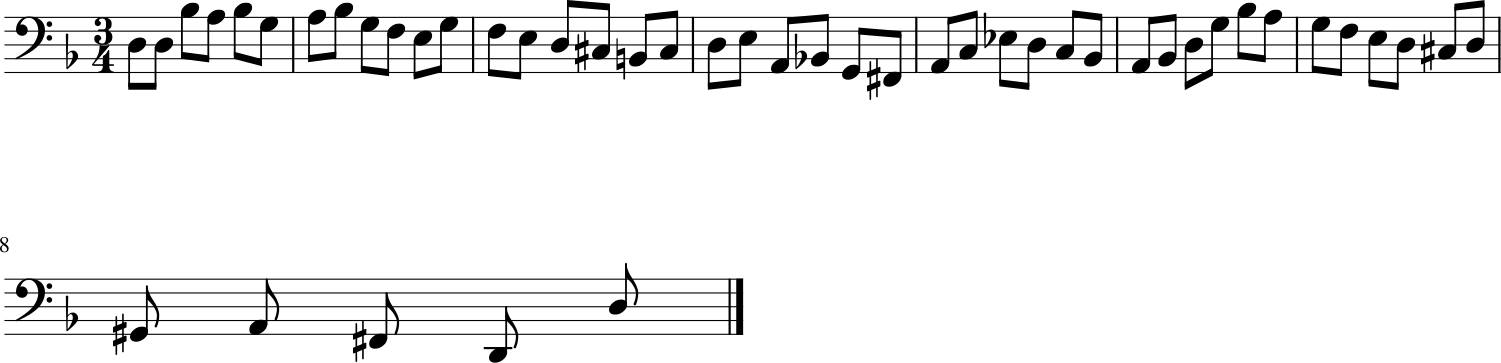

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 364ms/step - loss: 1.9956
Epoch 47/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.8823[['START', 'G:major', '4/4TS', 'G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'B3', 'D3', 'B3', 'D3', 'B3', 'D3', 'B3', 'D3', 'A3', 'D3', 'F#3', 'D3', 'E3', 'D3', 'D3', 'D3', 'E3', 'D3', 'C3', 'B2', 'A2', 'C3', 'A2', 'G2', 'D3', 'C3', 'A2', 'G2', 'D3', 'E-3', 'C3', 'B-3', 'C4', 'D4', 'E-4', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.25', '0.25', '0.25', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


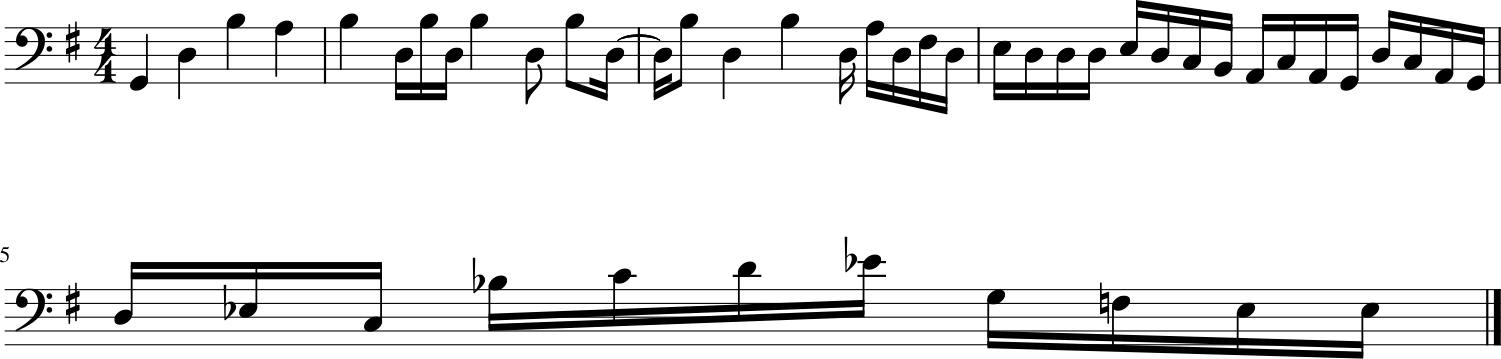

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 358ms/step - loss: 1.8829
Epoch 48/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.9255[['START', 'F:major', '3/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'E3', 'A3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'C3', 'B-2', 'A2', 'G2', 'F2', 'A2', 'D3', 'C3', 'F2', 'A3', 'D3', 'G3', 'F#3', 'G3', 'B-2', 'C3', 'E2', 'D2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


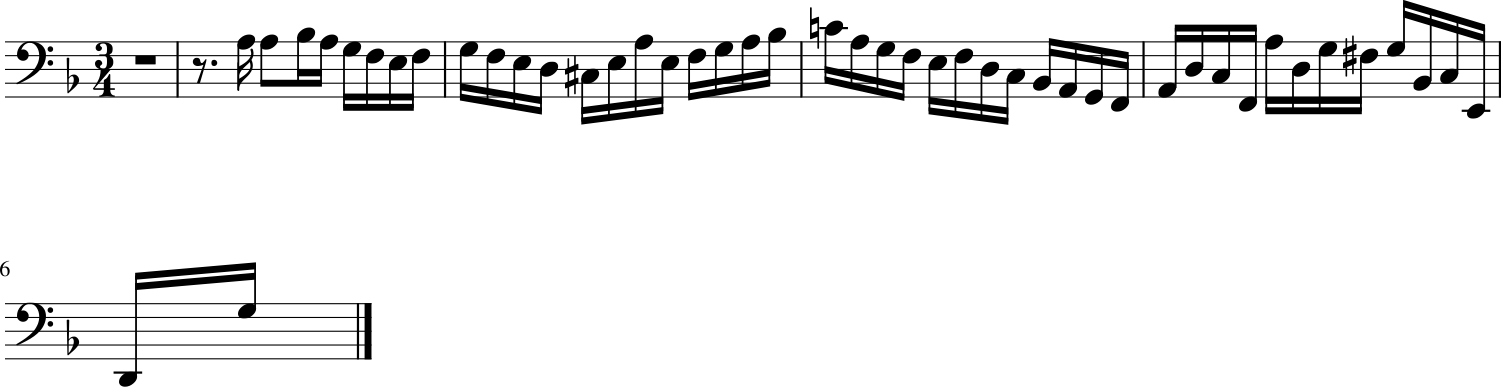

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 380ms/step - loss: 1.9258
Epoch 49/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.9412[['START', 'F:major', '3/4TS', 'rest', 'D4', 'D4', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B-3', 'F#3', 'G3', 'A3', 'E3', 'F#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'E3', 'F#3', 'D3', 'G2', 'B3', 'A3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


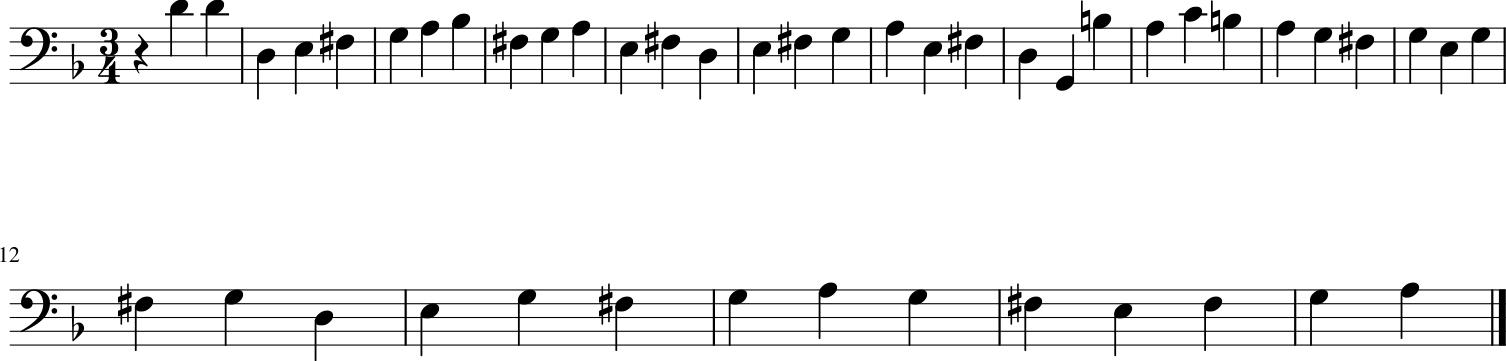

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - loss: 1.9412
Epoch 50/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.8530[['START', 'E-:major', '4/4TS', 'B-3', 'E-4', 'B-3', 'E-4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'G3', 'G#3', 'G3'], ['0.0', '2.75', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3']]


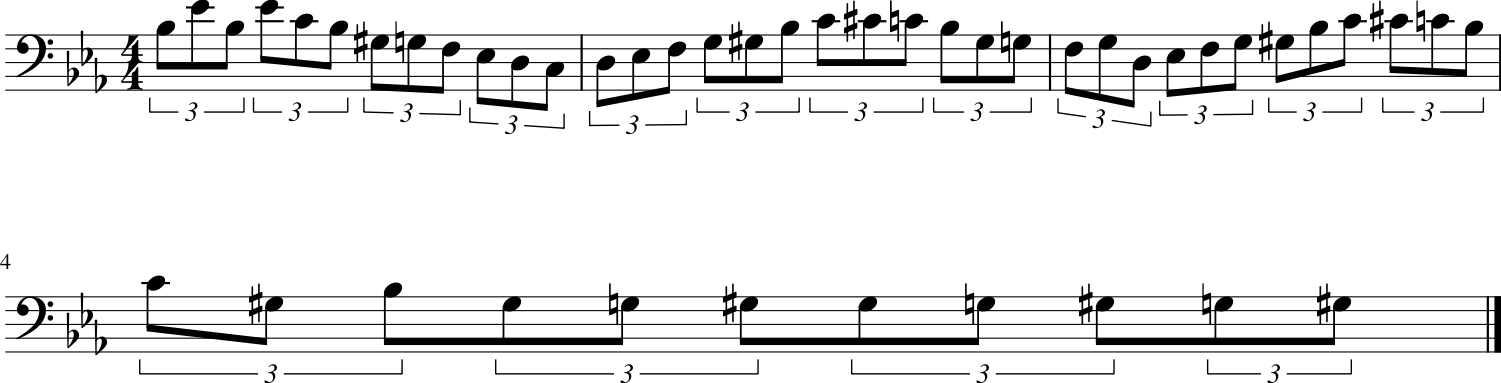

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 363ms/step - loss: 1.8536
Epoch 51/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.8536[['START', 'G:major', '6/8TS', 'rest', 'D3', 'G3', 'D3', 'E3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C#3', 'D3', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'E3', 'D3', 'C#3', 'D3', 'B2', 'G#3', 'F#3', 'A3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'A3', 'B3', 'C#4', 'A3', 'B3', 'C#4', 'A3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


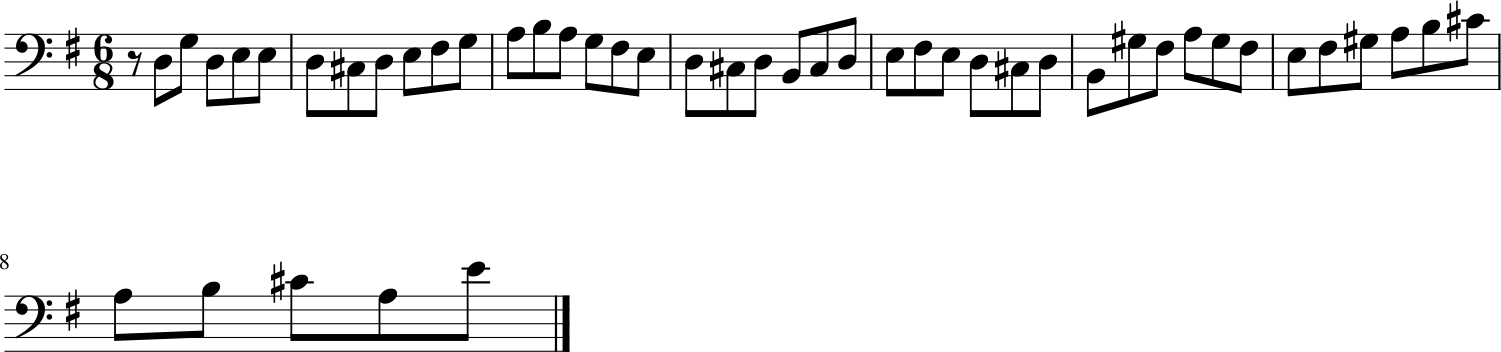

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 356ms/step - loss: 1.8543
Epoch 52/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.8673[['START', 'F:major', '3/4TS', 'E3', 'D3', 'E3', 'E3', 'D3', 'E3', 'D3', 'E3', 'D3', 'E3', 'D3', 'E3', 'D3', 'E3', 'D3', 'E3', 'D3', 'D4', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B-3', 'C4', 'B3', 'C4', 'A3', 'D4', 'F#3', 'G3', 'A3', 'D3', 'F#3', 'G3', 'A3', 'B3', 'G3', 'D3', 'B2', 'G2', 'G2', 'rest'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


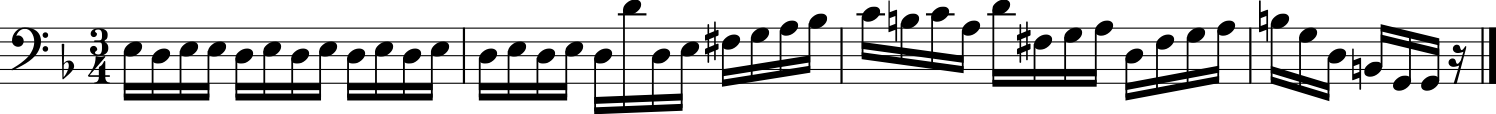

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 340ms/step - loss: 1.8677
Epoch 53/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.9008[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


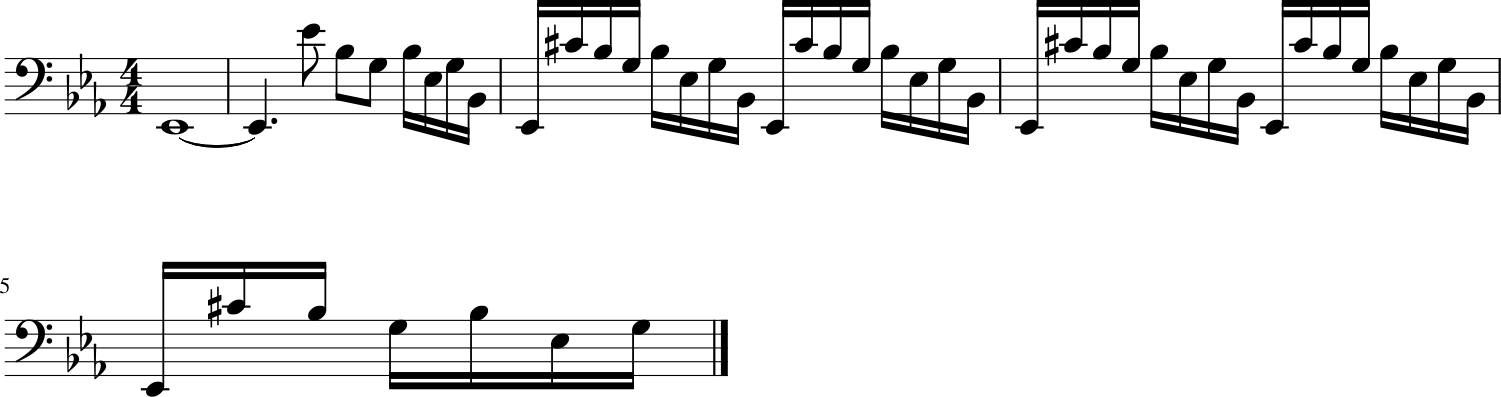

107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 364ms/step - loss: 1.9007
Epoch 54/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.8572[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'rest', 'G3', 'E-3', 'C3', 'B-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


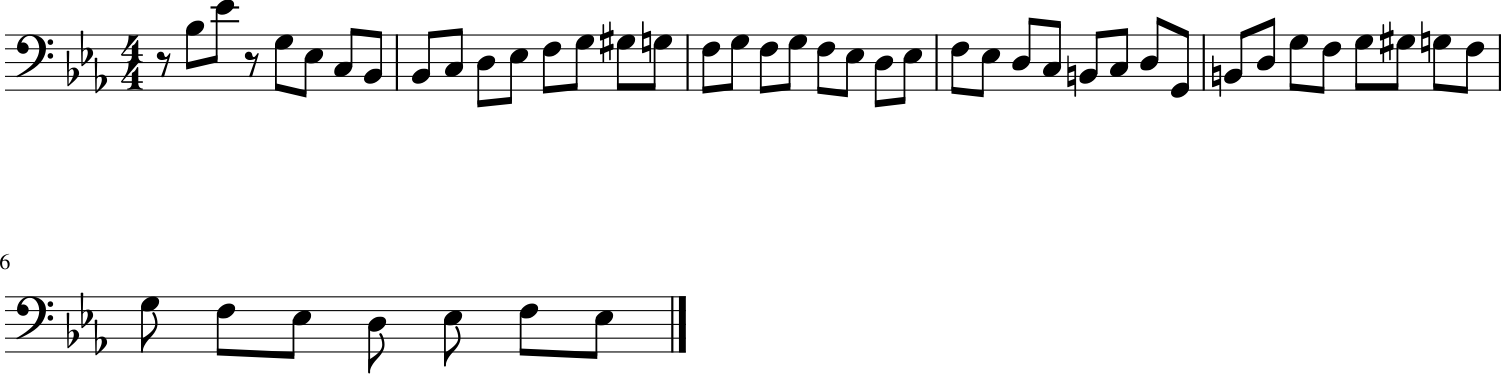

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - loss: 1.8574
Epoch 55/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.8456[['START', 'G:major', '4/4TS', 'D4', 'D3', 'B3', 'G3', 'D3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E3', 'A2', 'C3', 'D3', 'B2', 'D3', 'A2', 'D3', 'C3', 'A2', 'B2', 'D3', 'A2', 'D3', 'C3', 'D3', 'B2', 'D3', 'A2', 'D3', 'C3', 'D3', 'B2', 'D3', 'A2', 'D3', 'C3', 'D3', 'B2', 'D3', 'A2', 'D3', 'C3', 'D3', 'E3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


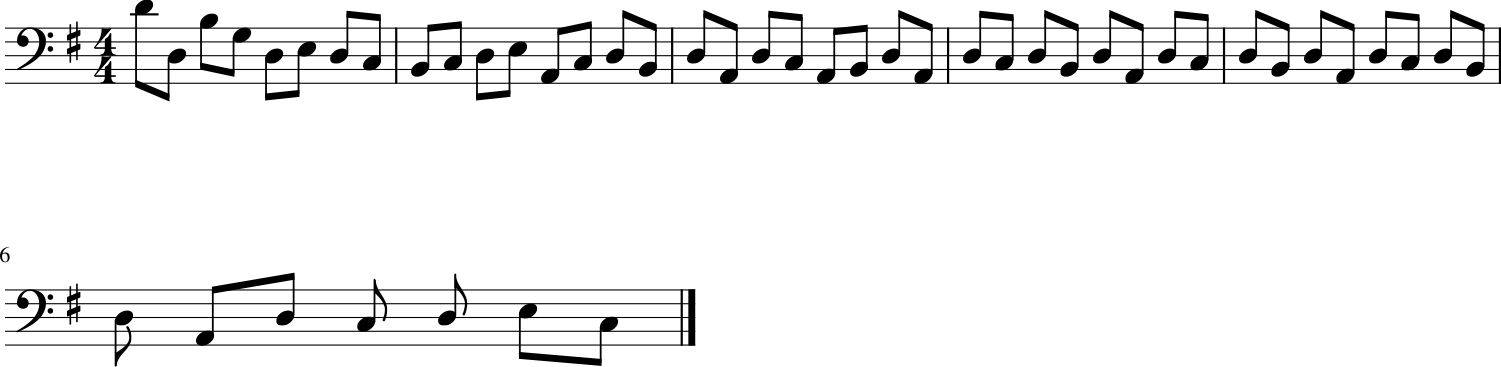

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 355ms/step - loss: 1.8459
Epoch 56/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.8229[['START', 'E-:major', '4/4TS', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'C4', 'G#3', 'D3', 'C4', 'B-3', 'E-3', 'D3', 'F3', 'B-2', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'E-4', 'E-3', 'F3', 'G3', 'G#3', 'B-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


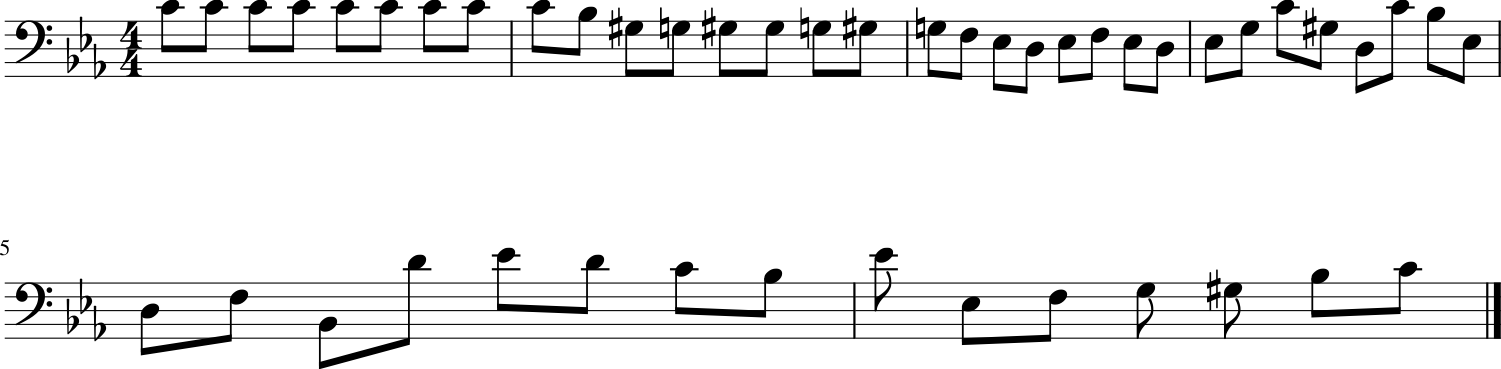

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - loss: 1.8233
Epoch 57/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.7670[['START', 'E-:major', '3/4TS', 'E-3', 'D3', 'E-3', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3'], ['0.0', '0.0', '0.0', '2.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


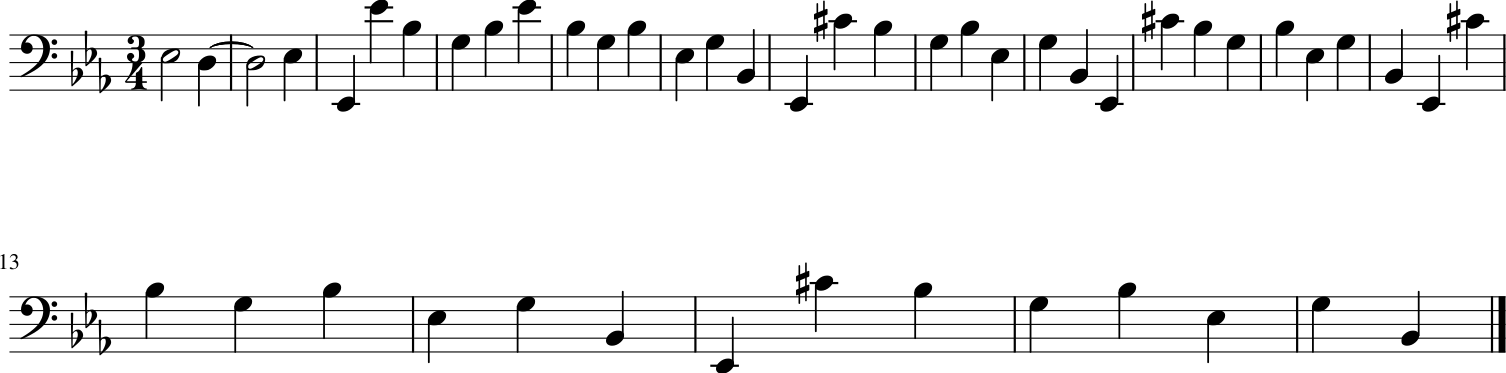

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - loss: 1.7677
Epoch 58/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.7254[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'E-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


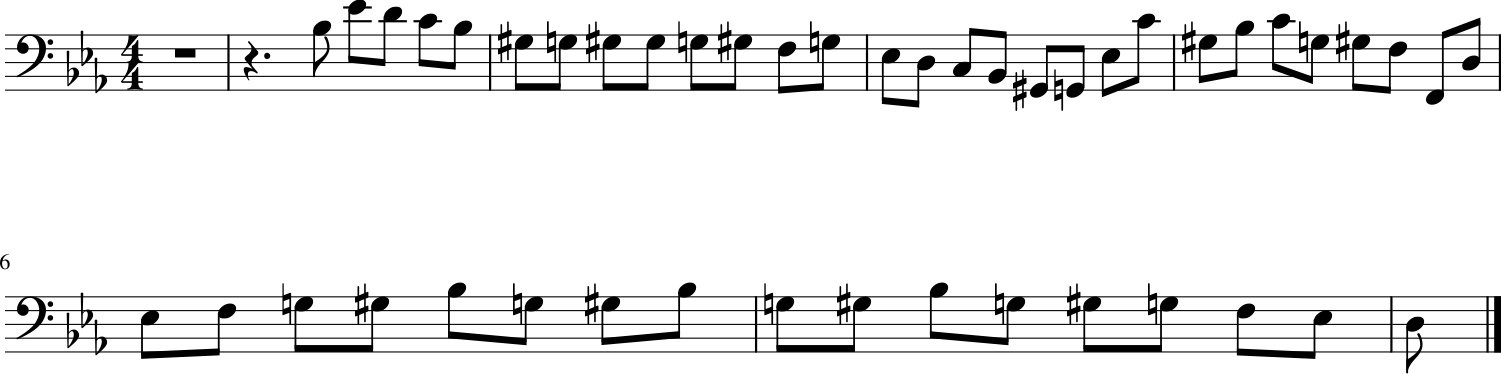

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 361ms/step - loss: 1.7264
Epoch 59/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.7541[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'G3', 'G#3', 'B-3', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3'], ['0.0', '0.0', '0.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


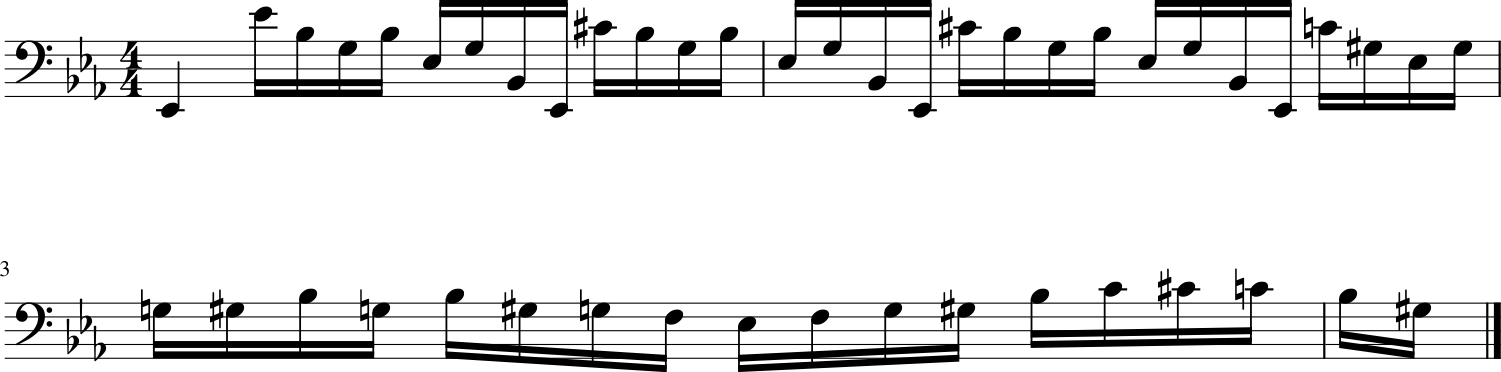

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - loss: 1.7548
Epoch 60/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.7815[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'F#3', 'G3', 'E3', 'D3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'D3', 'C3', 'A2', 'B2', 'A2', 'G2', 'F#2', 'A2', 'D3', 'C3', 'A2', 'B2', 'A2', 'G2', 'B2', 'D3', 'F3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.25', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


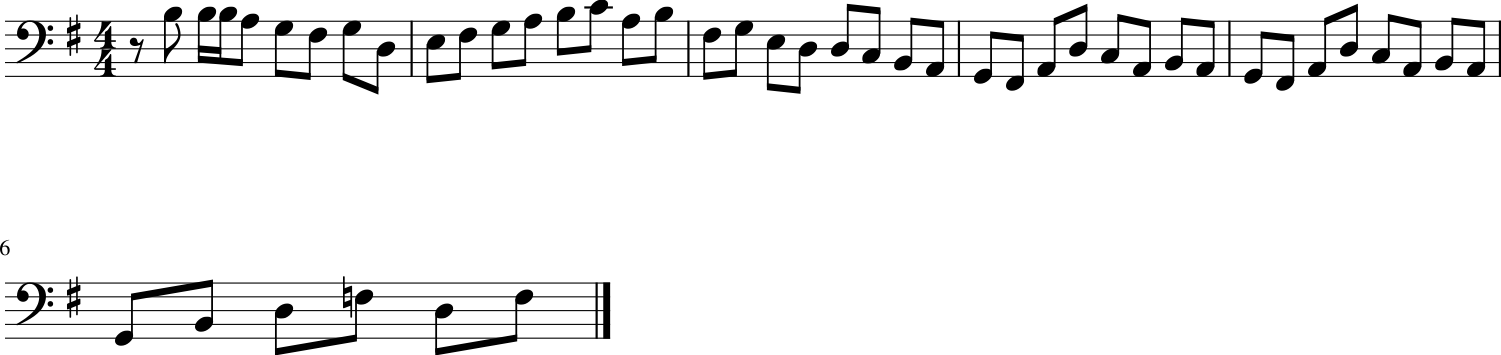

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 360ms/step - loss: 1.7818
Epoch 61/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.7148[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


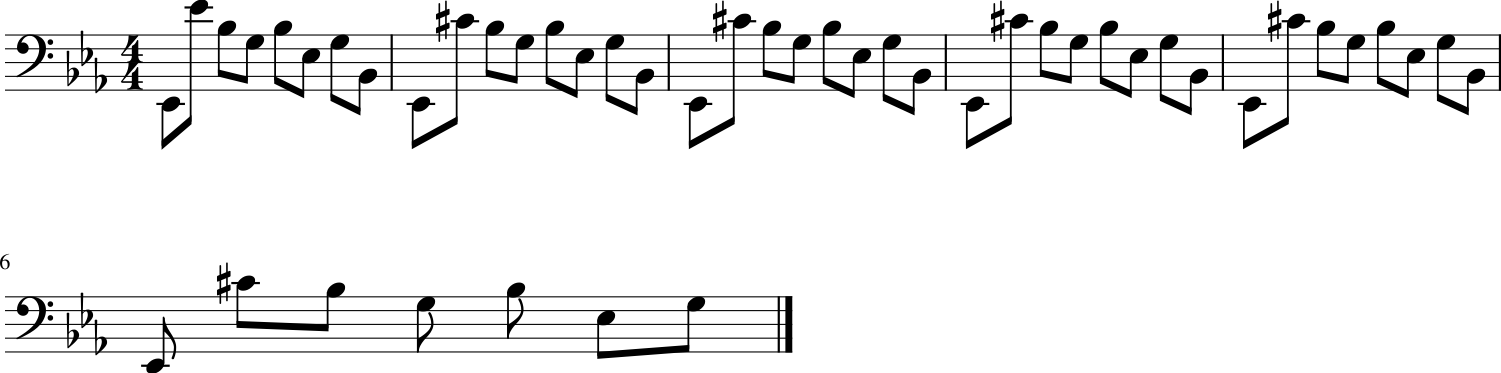

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - loss: 1.7157
Epoch 62/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.7607[['START', 'E-:major', '4/4TS', 'C3', 'G2', 'A2', 'B2', 'C3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B2', 'C3', 'D3', 'C3', 'D3', 'C3', 'D3', 'E3', 'C3', 'A2', 'G#2', 'G2', 'A2', 'B2', 'G2', 'E3', 'G2', 'C3', 'G2', 'A2', 'B2', 'G2', 'A2', 'G2', 'A2', 'G2', 'A2', 'G2', 'A2', 'G2', 'A2', 'G2', 'A2', 'G2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


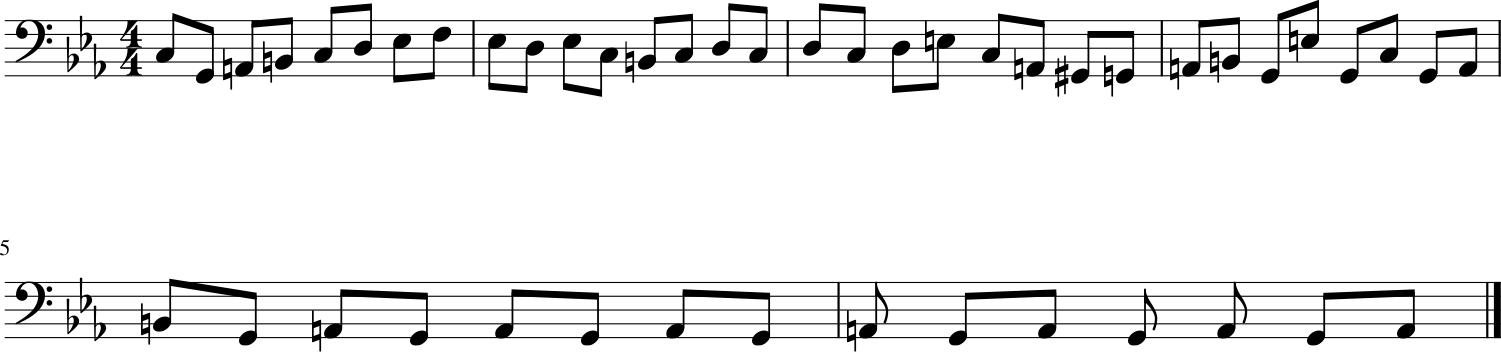

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 361ms/step - loss: 1.7611
Epoch 63/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.7881[['START', 'G:major', '4/4TS', 'D4', 'C#4', 'B3', 'B3', 'A3', 'B3', 'C4', 'G#3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'D4', 'B2', 'C#3', 'A2', 'E3', 'A3', 'C#4', 'D4', 'E4', 'A3', 'C#4', 'E4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'D3', 'A2', 'D3', 'F#3', 'E3', 'D3', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


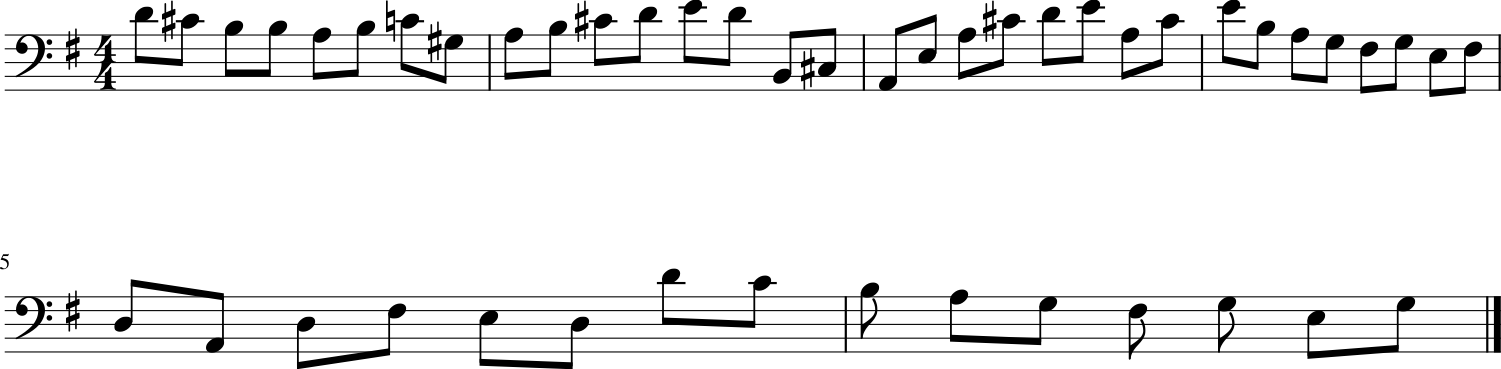

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 357ms/step - loss: 1.7882
Epoch 64/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.7410[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'D3', 'E-2', 'G3', 'F3', 'E-3', 'F3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'B-3', 'G3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


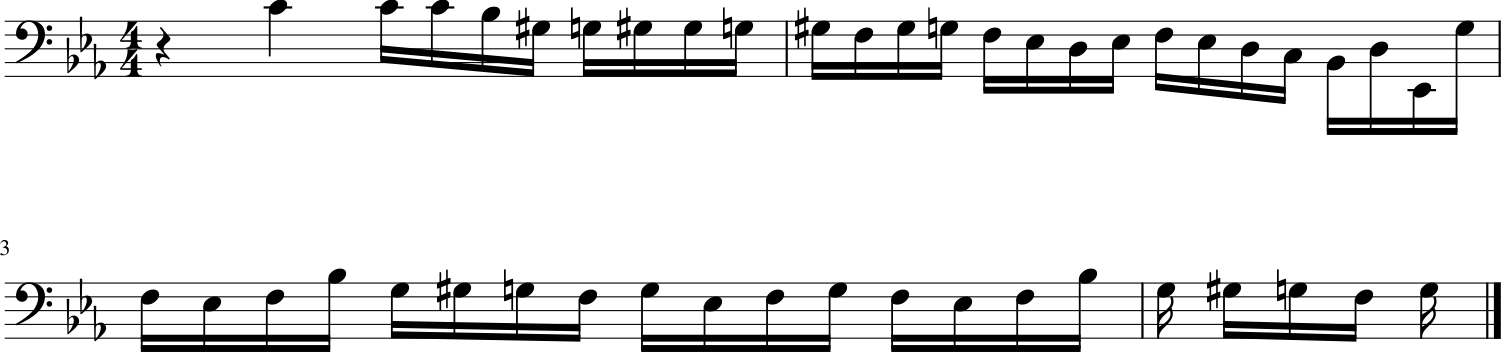

107/107 ━━━━━━━━━━━━━━━━━━━━ 97s 884ms/step - loss: 1.7413
Epoch 65/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.6899[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'E-3', 'F3', 'G3', 'D3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.75', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


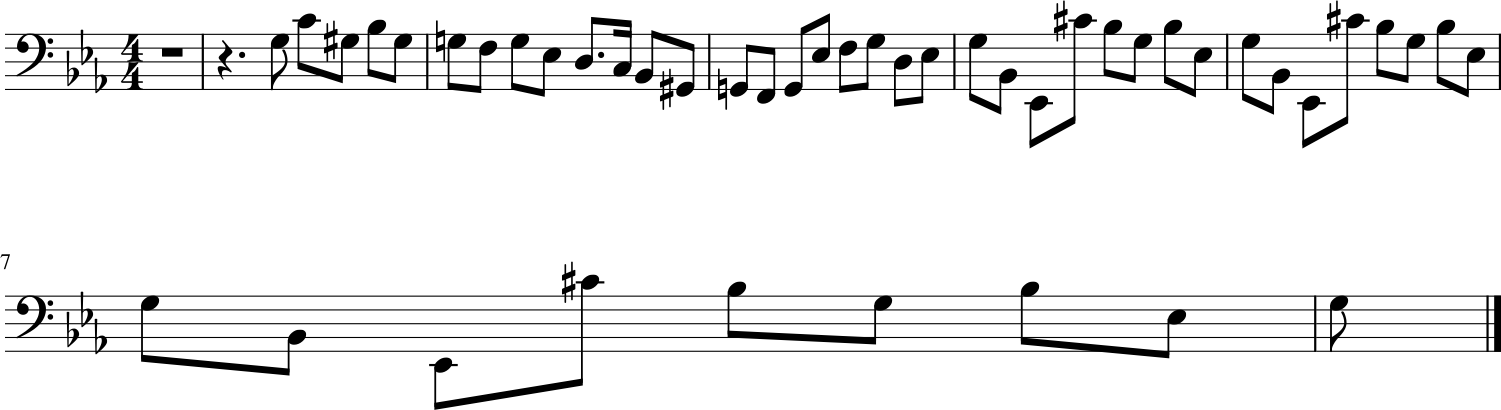

107/107 ━━━━━━━━━━━━━━━━━━━━ 5769s 54s/step - loss: 1.6908
Epoch 66/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.7605[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'G#3', 'F3', 'D4', 'F3', 'D4', 'D4', 'C#4', 'C#4', 'B3', 'A3', 'G#3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'G#4', 'A4', 'B4', 'D4', 'C#4', 'A3', 'B3', 'C#4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


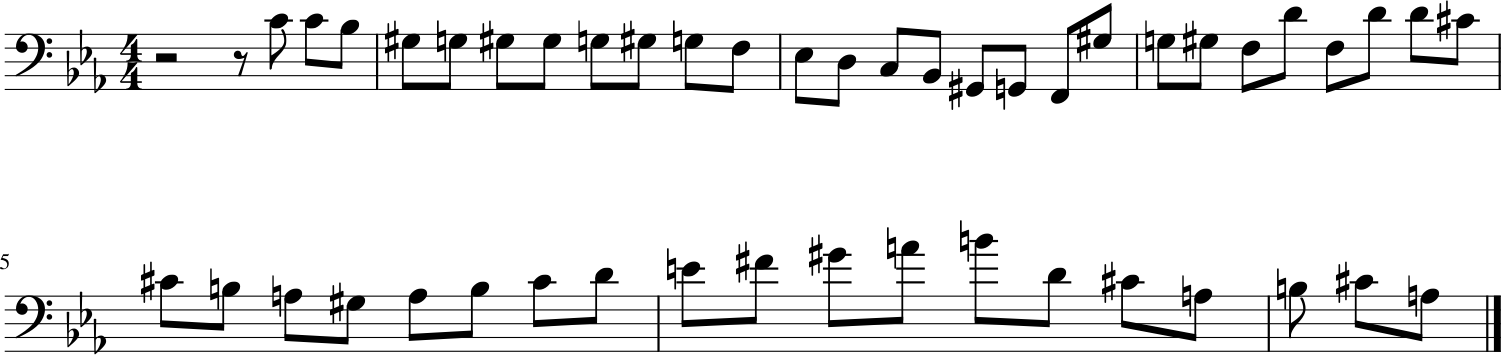

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 365ms/step - loss: 1.7606
Epoch 67/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.7320[['START', 'E-:major', '3/4TS', 'rest', 'E-3', 'E-3', 'B-2', 'C3', 'G#2', 'F2', 'D3', 'E-3', 'E-2', 'D3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'D3', 'E-3', 'G2', 'F2', 'A3', 'D3', 'G3', 'F#3', 'G3', 'B-2', 'C3', 'E2', 'D2', 'G3', 'F#3', 'B-3', 'A3', 'B-3', 'D3', 'E-3', 'G2', 'F2', 'A3', 'D3', 'G3', 'F#3'], ['0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


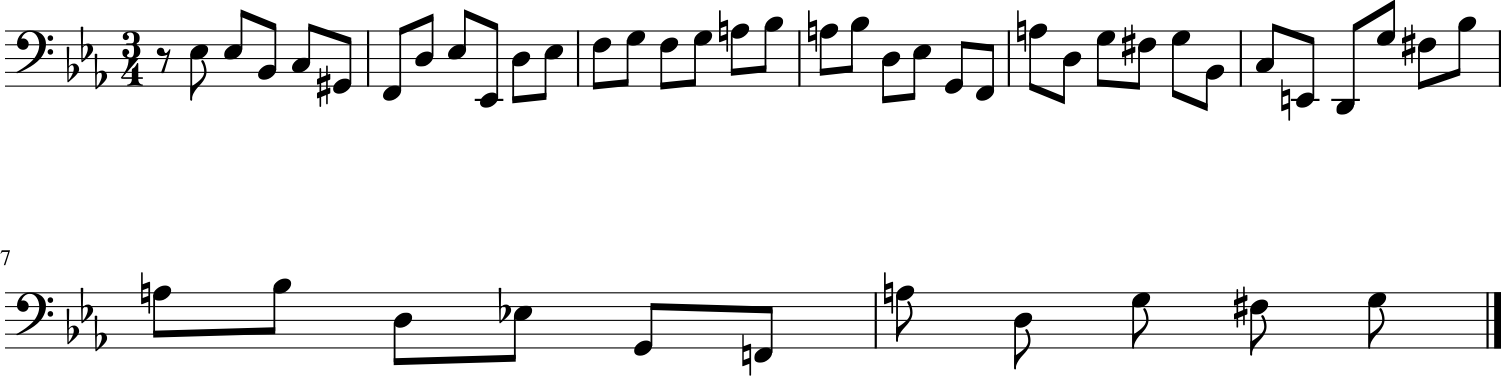

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - loss: 1.7323
Epoch 68/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.6925[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'E-3', 'B-2', 'C3', 'G#2', 'F2', 'D3', 'E-3', 'F3', 'G3', 'D3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


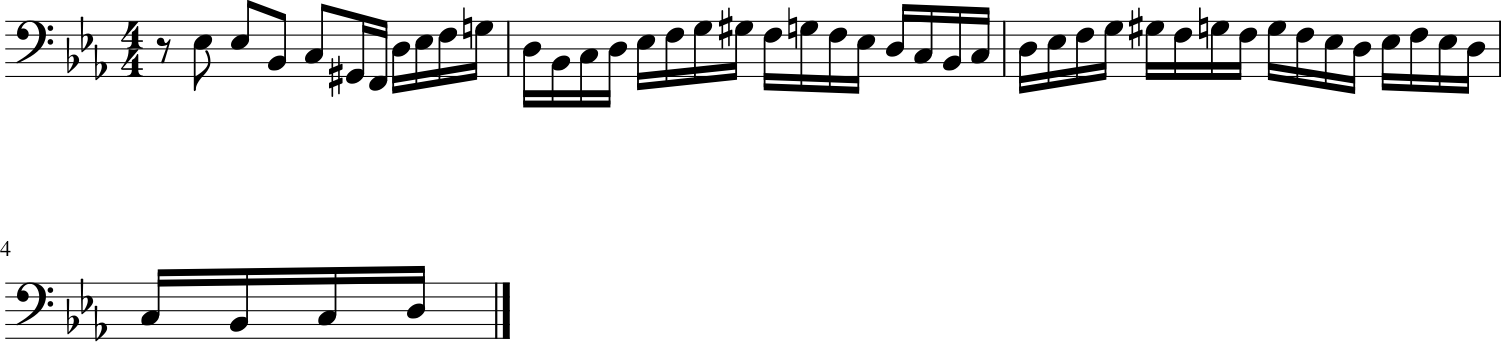

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 370ms/step - loss: 1.6931
Epoch 69/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.6711[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'G3', 'C4', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


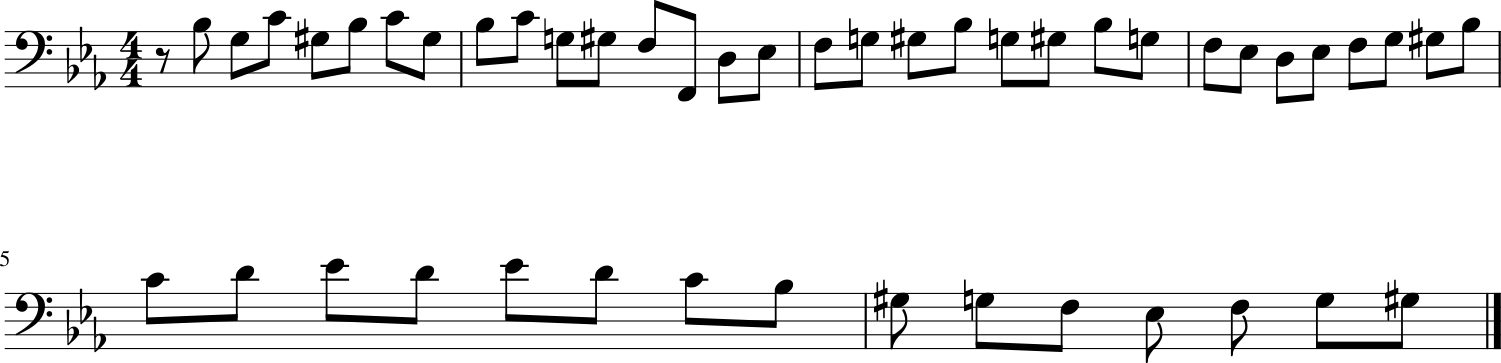

107/107 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - loss: 1.6717
Epoch 70/1500
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.6897

In [ ]:
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

In [ ]:
# Save the final model
model.save("./models/model")

# 3. Generate music using the Transformer

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

## Write music to MIDI file

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/output",
        "output-" + timestr + ".mid",
    ),
)

## Note probabilities

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()